In [1]:
import pytz, os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.getcwd(), '..'))

from scripts.decomposition import perform_mstl
from scripts.correlate import analyze_weather_impact, analyze_all_conditions
from scripts.ingest import build_mta_df, get_combined_residuals_df
from scripts.filter import filter_df_by_hour_range, filter_date_range, split_df_at_datetime, TimeInterval
from datetime import datetime, timedelta
from scripts.model import *
from scripts.parameter_search import *


In [2]:
assets_path = os.path.join(os.getcwd(), '..', 'assets')

hourly_subway_df, hourly_bus_df, weather_df = build_mta_df(
    os.path.join(assets_path, 'hourly_subway_ridership.csv'),
    os.path.join(assets_path, 'hourly_bus_ridership.csv'),
    os.path.join(assets_path, 'nyc_hourly_weather.csv')
)

/Users/perryscott/Desktop/MTA-Weather-Based-Prediction/notebooks/../scripts/ingest.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  hourly_bus_df['hour'] = pd.to_datetime(hourly_bus_df['hour'])
/Users/perryscott/Desktop/MTA-Weather-Based-Prediction/notebooks/../scripts/ingest.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  hourly_subway_df['hour'] = pd.to_datetime(hourly_subway_df['hour'])


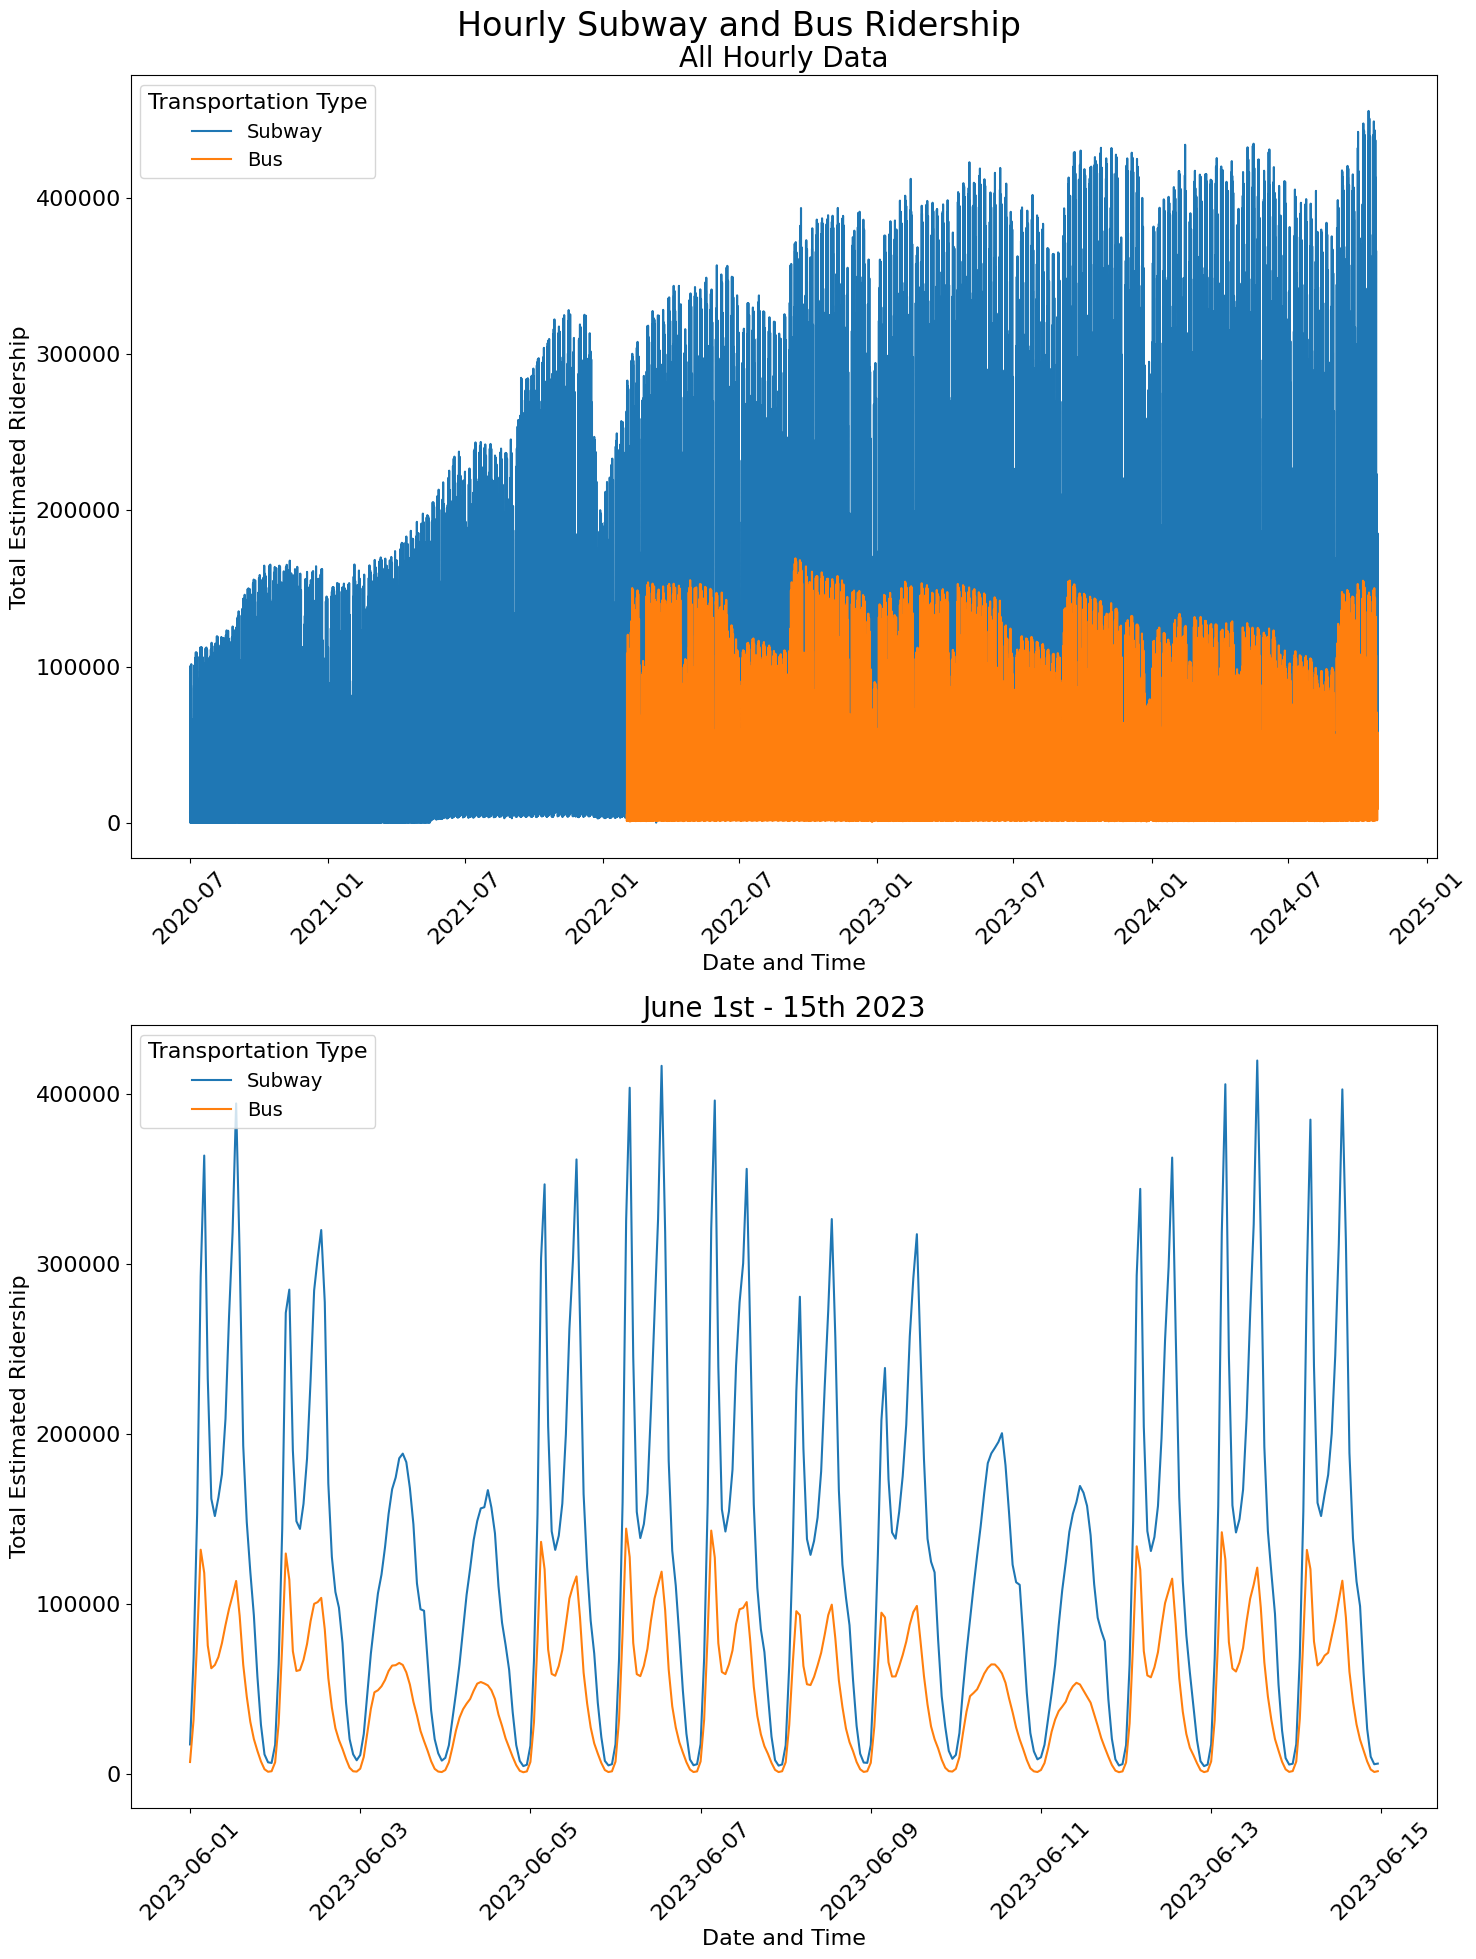

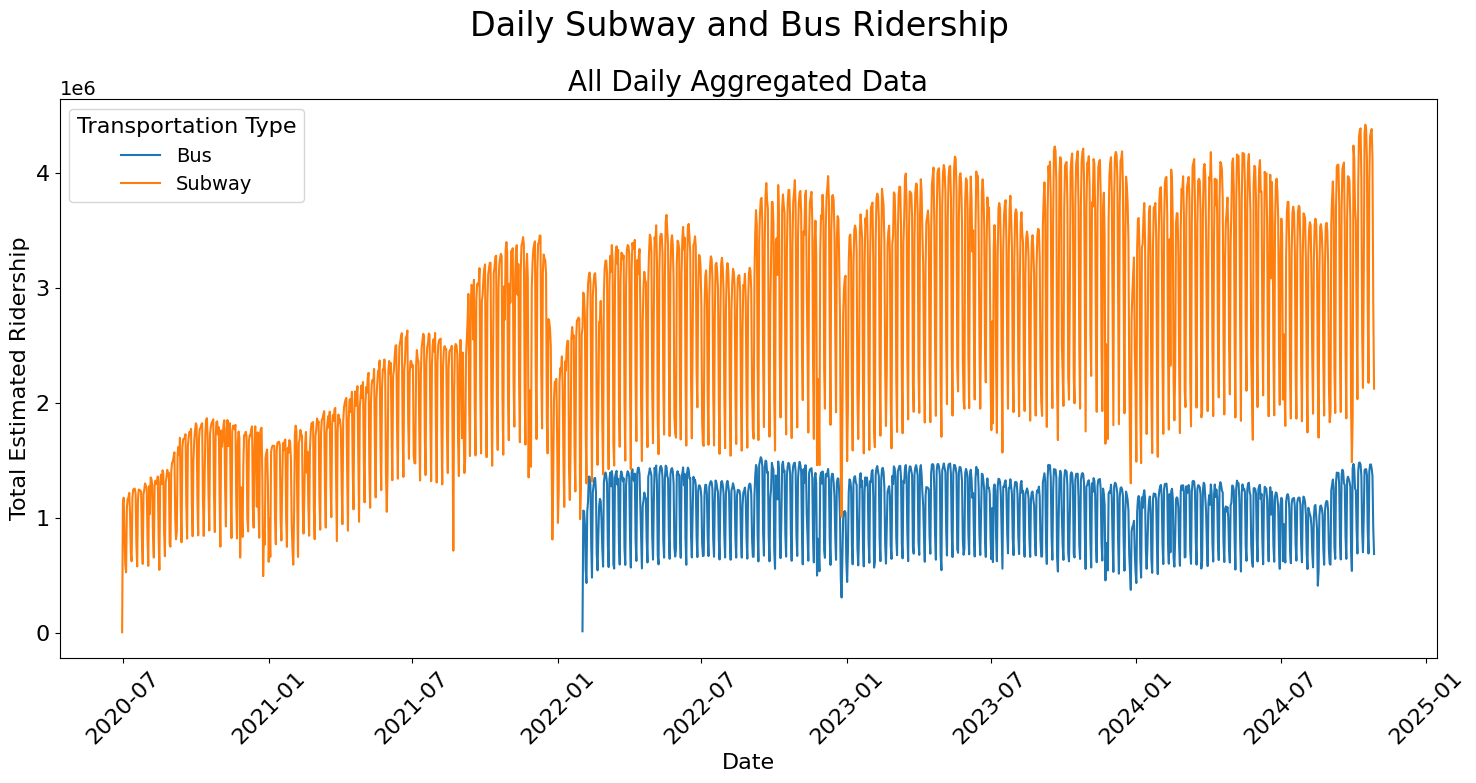

In [3]:
# Combine subway and bus hourly data
combined_hourly_df = pd.concat([hourly_subway_df, hourly_bus_df])

# Aggregate hourly data to daily
daily_combined_df = combined_hourly_df.groupby(['transportation', combined_hourly_df['hour'].dt.date])['total_ridership'].sum().reset_index()
daily_combined_df['hour'] = pd.to_datetime(daily_combined_df['hour'])

# Set up the plots with larger font sizes
plt.rcParams.update({'font.size': 14})  

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('Hourly Subway and Bus Ridership', fontsize=24)

# Plot subway and bus ridership for all hourly data
sns.lineplot(x='hour', y='total_ridership', hue='transportation', data=combined_hourly_df, ax=ax1)
ax1.set_title('All Hourly Data', fontsize=20)
ax1.set_xlabel('Date and Time', fontsize=16)
ax1.set_ylabel('Total Estimated Ridership', fontsize=16)
ax1.legend(title='Transportation Type', title_fontsize='16', fontsize='14')
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

start_month = pd.Timestamp('2023-06-01')
end_month = pd.Timestamp('2023-06-15')

# Filter data for the random month
random_month_data = combined_hourly_df[(combined_hourly_df['hour'] >= start_month) & (combined_hourly_df['hour'] < end_month)]

# Plot subway and bus ridership for the random month
sns.lineplot(x='hour', y='total_ridership', hue='transportation', data=random_month_data, ax=ax2)
ax2.set_title('June 1st - 15th 2023', fontsize=20)
ax2.set_xlabel('Date and Time', fontsize=16)
ax2.set_ylabel('Total Estimated Ridership', fontsize=16)
ax2.legend(title='Transportation Type', title_fontsize='16', fontsize='14')
ax2.tick_params(axis='x', rotation=45, labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()

# Create a new figure for the daily aggregated data
fig2, ax3 = plt.subplots(figsize=(15, 8))
fig2.suptitle('Daily Subway and Bus Ridership', fontsize=24)

# Plot subway and bus ridership for all daily aggregated data
sns.lineplot(x='hour', y='total_ridership', hue='transportation', data=daily_combined_df, ax=ax3)
ax3.set_title('All Daily Aggregated Data', fontsize=20)
ax3.set_xlabel('Date', fontsize=16)
ax3.set_ylabel('Total Estimated Ridership', fontsize=16)
ax3.legend(title='Transportation Type', title_fontsize='16', fontsize='14')
ax3.tick_params(axis='x', rotation=45, labelsize=16)
ax3.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


Sanity check to make sure daily and hourly data align with eachother

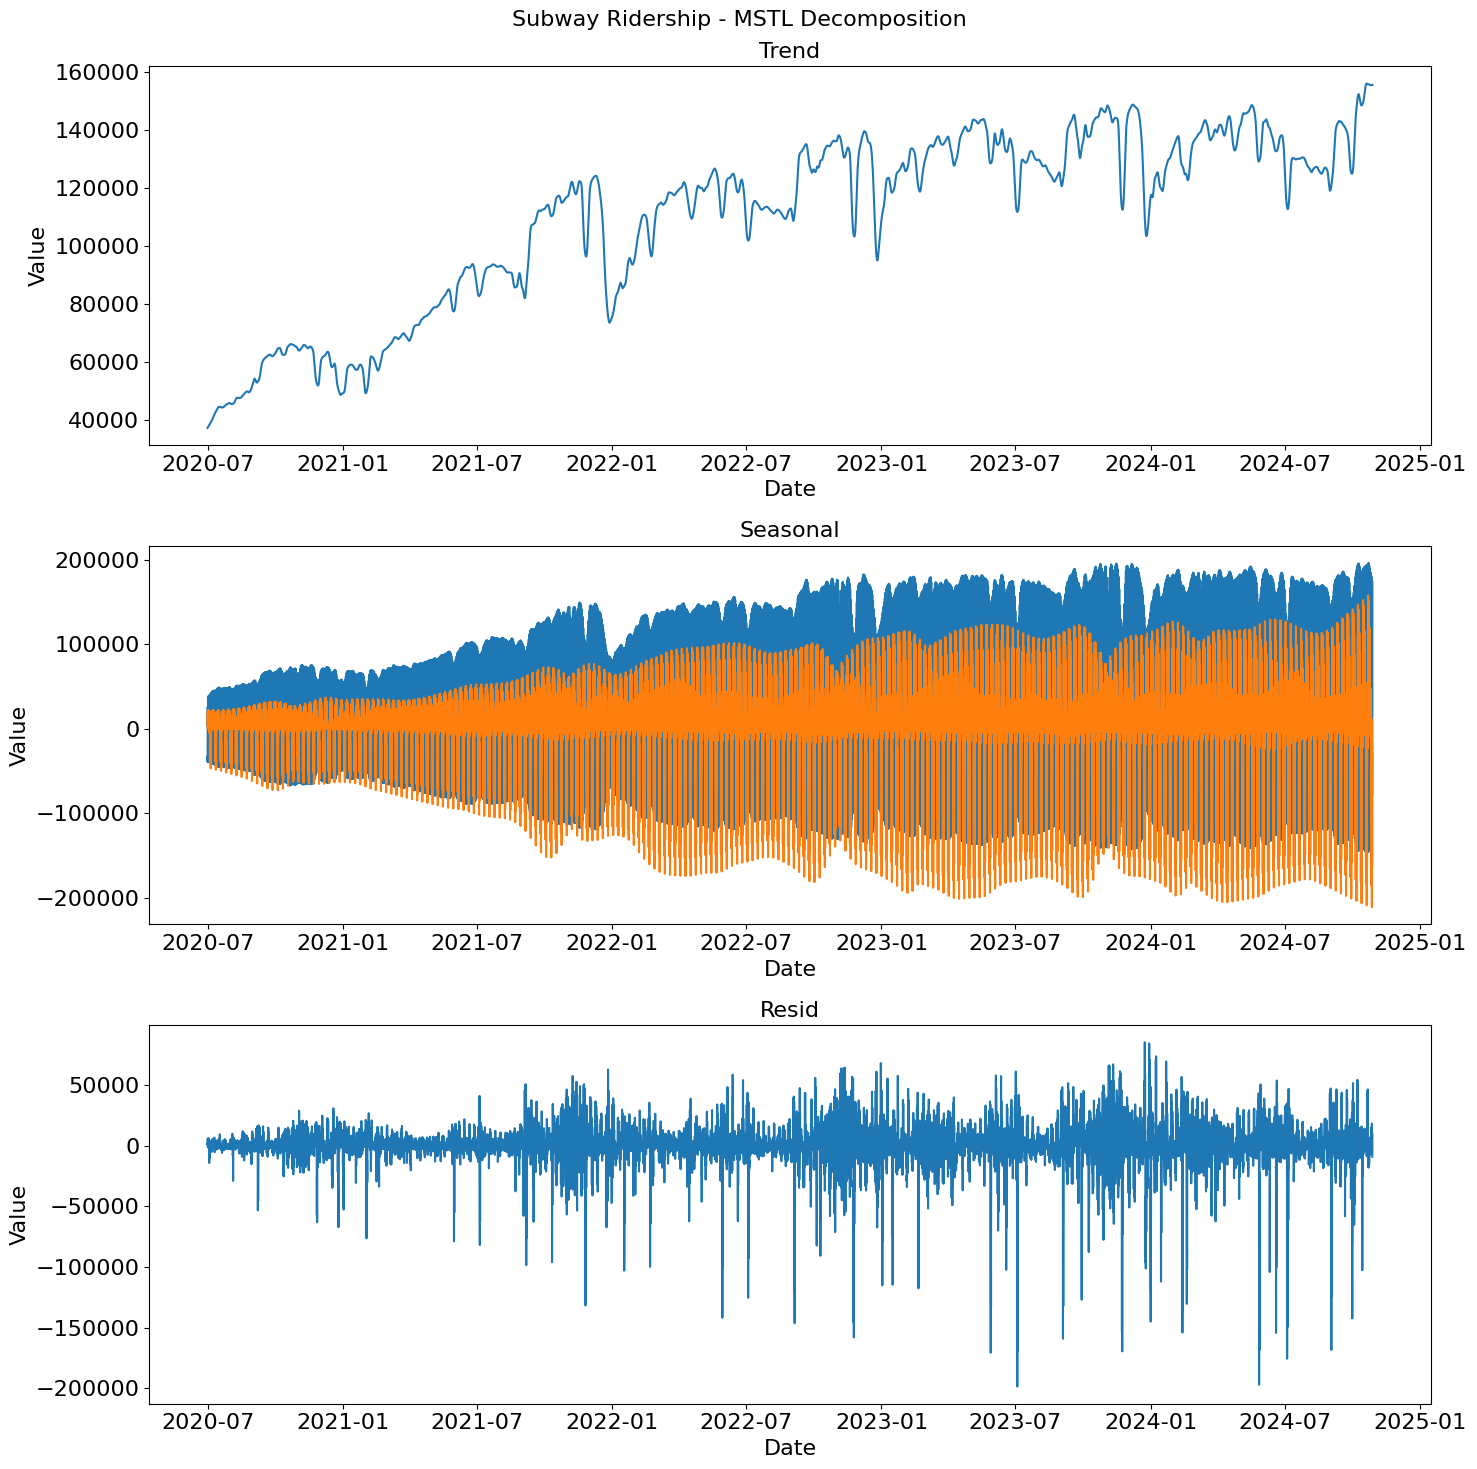

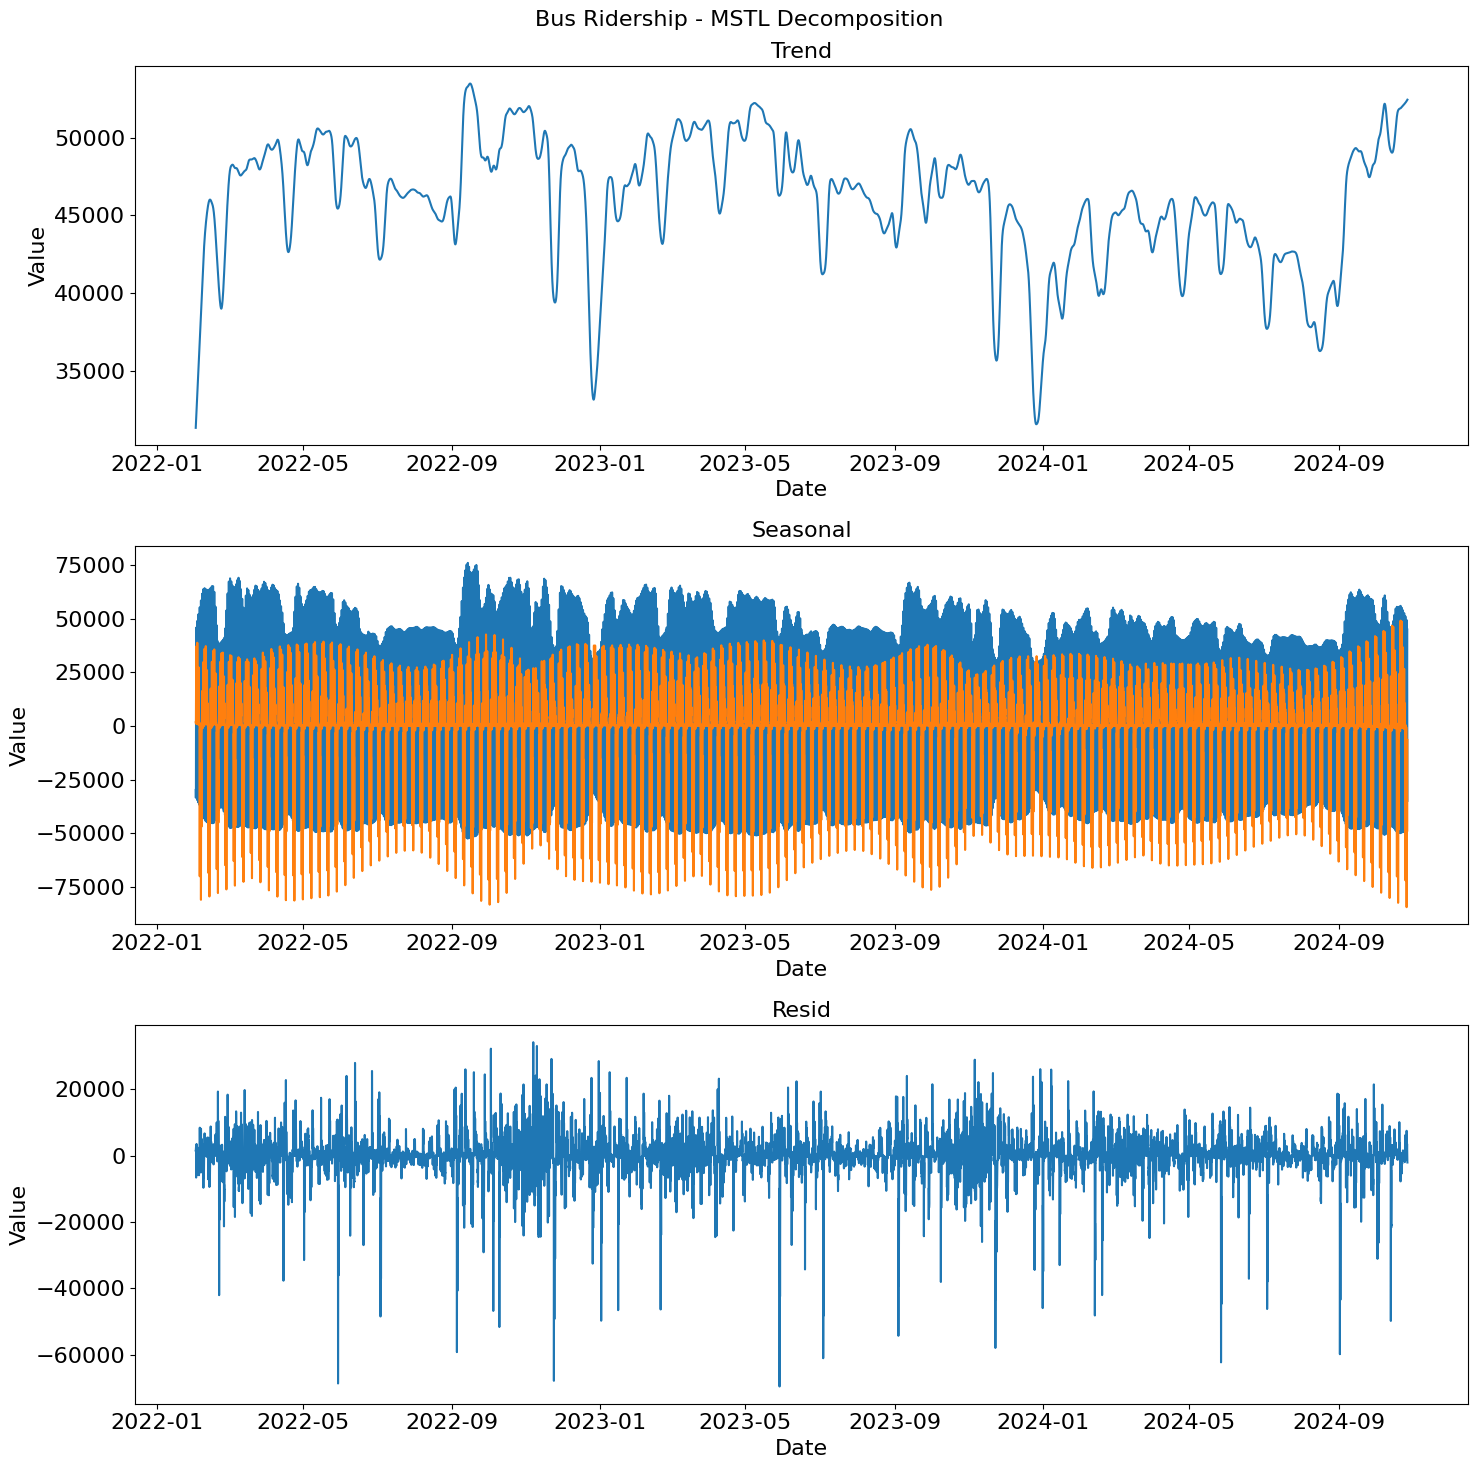

In [4]:
# Perform MSTL decomposition for subway data
subway_decomposition = perform_mstl(hourly_subway_df['total_ridership'], periods=[24, 24*7])

# Perform MSTL decomposition for bus data
bus_decomposition = perform_mstl(hourly_bus_df['total_ridership'], periods=[24, 24*7])

# Plot the decomposition results
def plot_decomposition(decomposition, title, df):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)
    
    components = ['trend', 'seasonal', 'resid']
    
    for i, component in enumerate(components):
        axs[i].plot(df['hour'], getattr(decomposition, component))
        axs[i].set_title(component.capitalize(), fontsize=16)
        axs[i].set_xlabel('Date', fontsize=16)
        axs[i].set_ylabel('Value', fontsize=16)
        axs[i].tick_params(axis='both', which='major', labelsize=16)
        
        if component == 'resid':
            # Find the 20 biggest outliers
            residuals = getattr(decomposition, component)
            outliers = np.abs(residuals).nlargest(20)
            
            # # Print the times of the outliers
            # print(f"\n20 biggest outliers for {title}:")
            # for time, value in zip(df['hour'].iloc[outliers.index], outliers):
            #     print(f"Time: {time}, Residual: {value}")
        
    plt.tight_layout()
    plt.show()

# Plot decomposition for subway data
plot_decomposition(subway_decomposition, 'Subway Ridership - MSTL Decomposition', hourly_subway_df)

# Plot decomposition for bus data
plot_decomposition(bus_decomposition, 'Bus Ridership - MSTL Decomposition', hourly_bus_df)


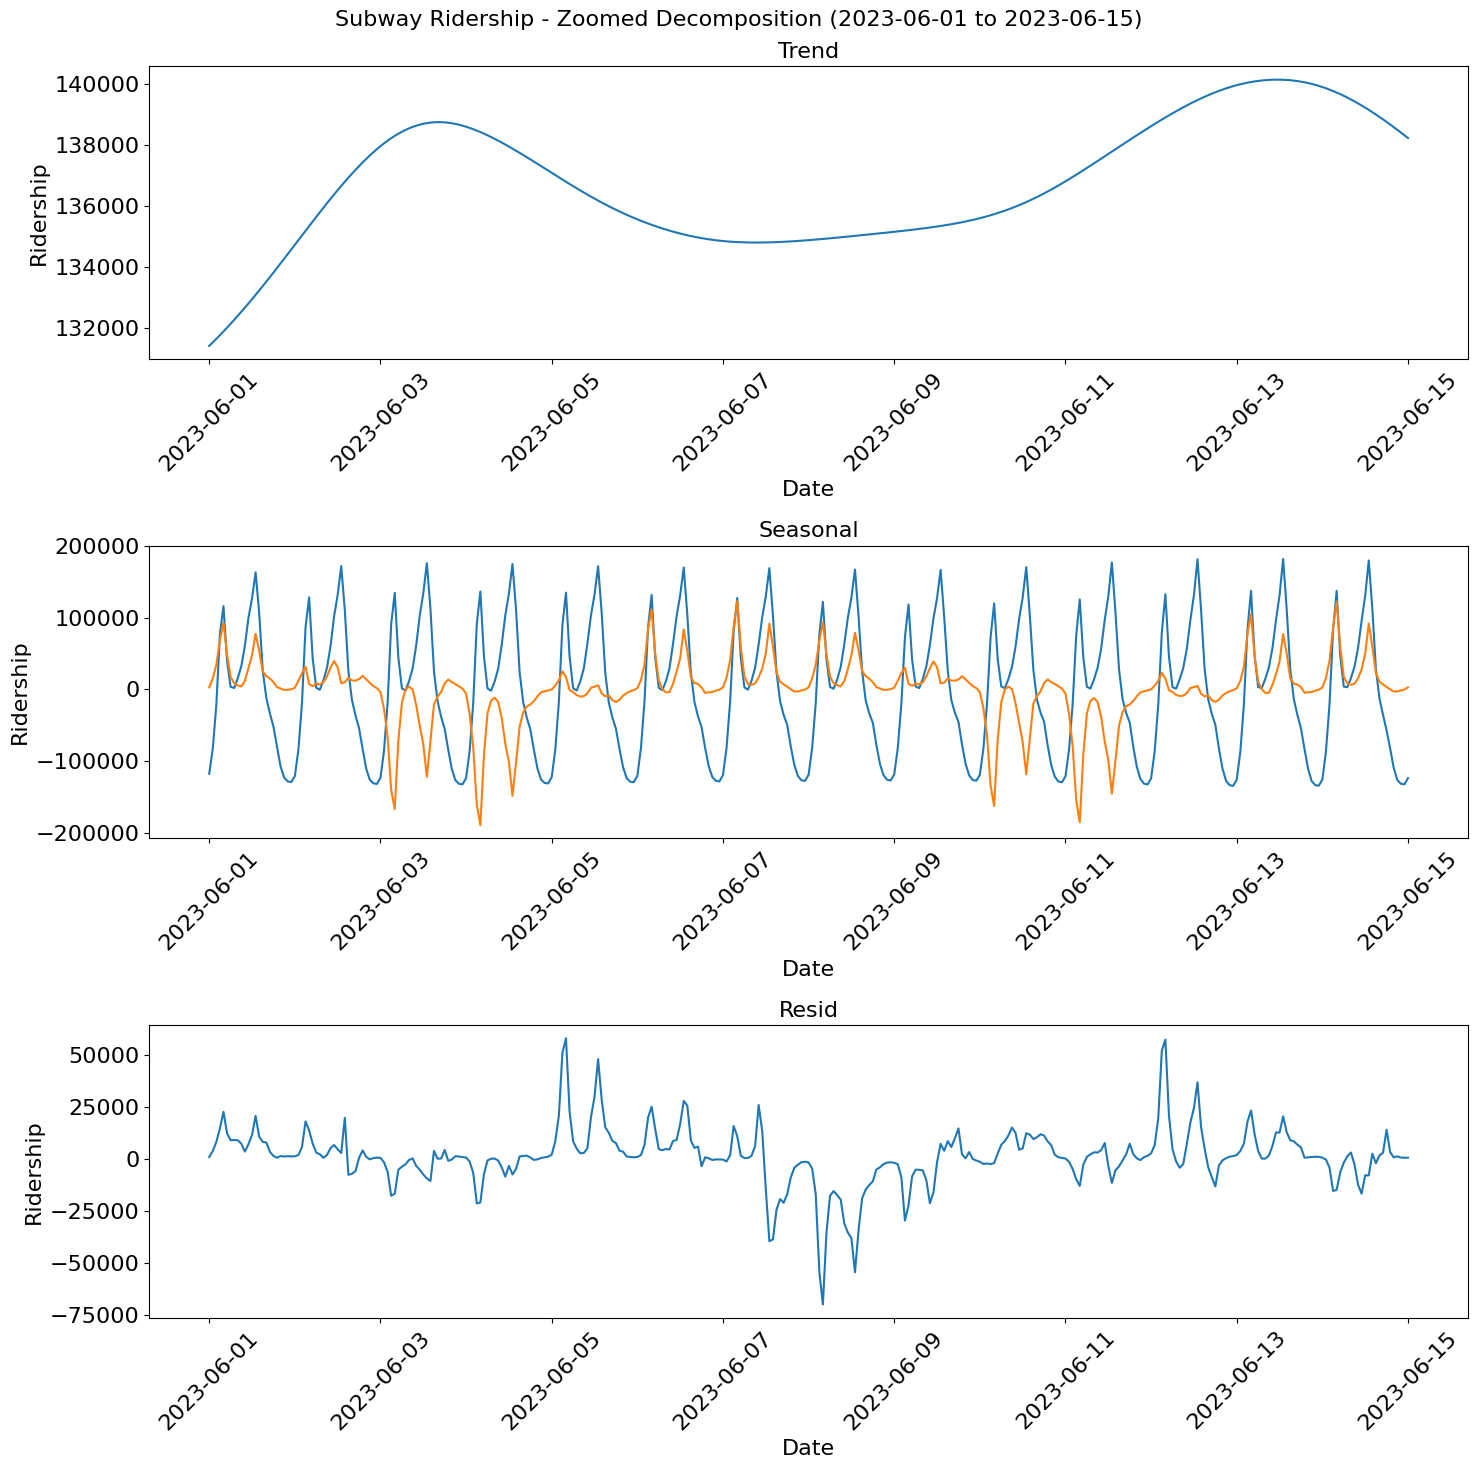

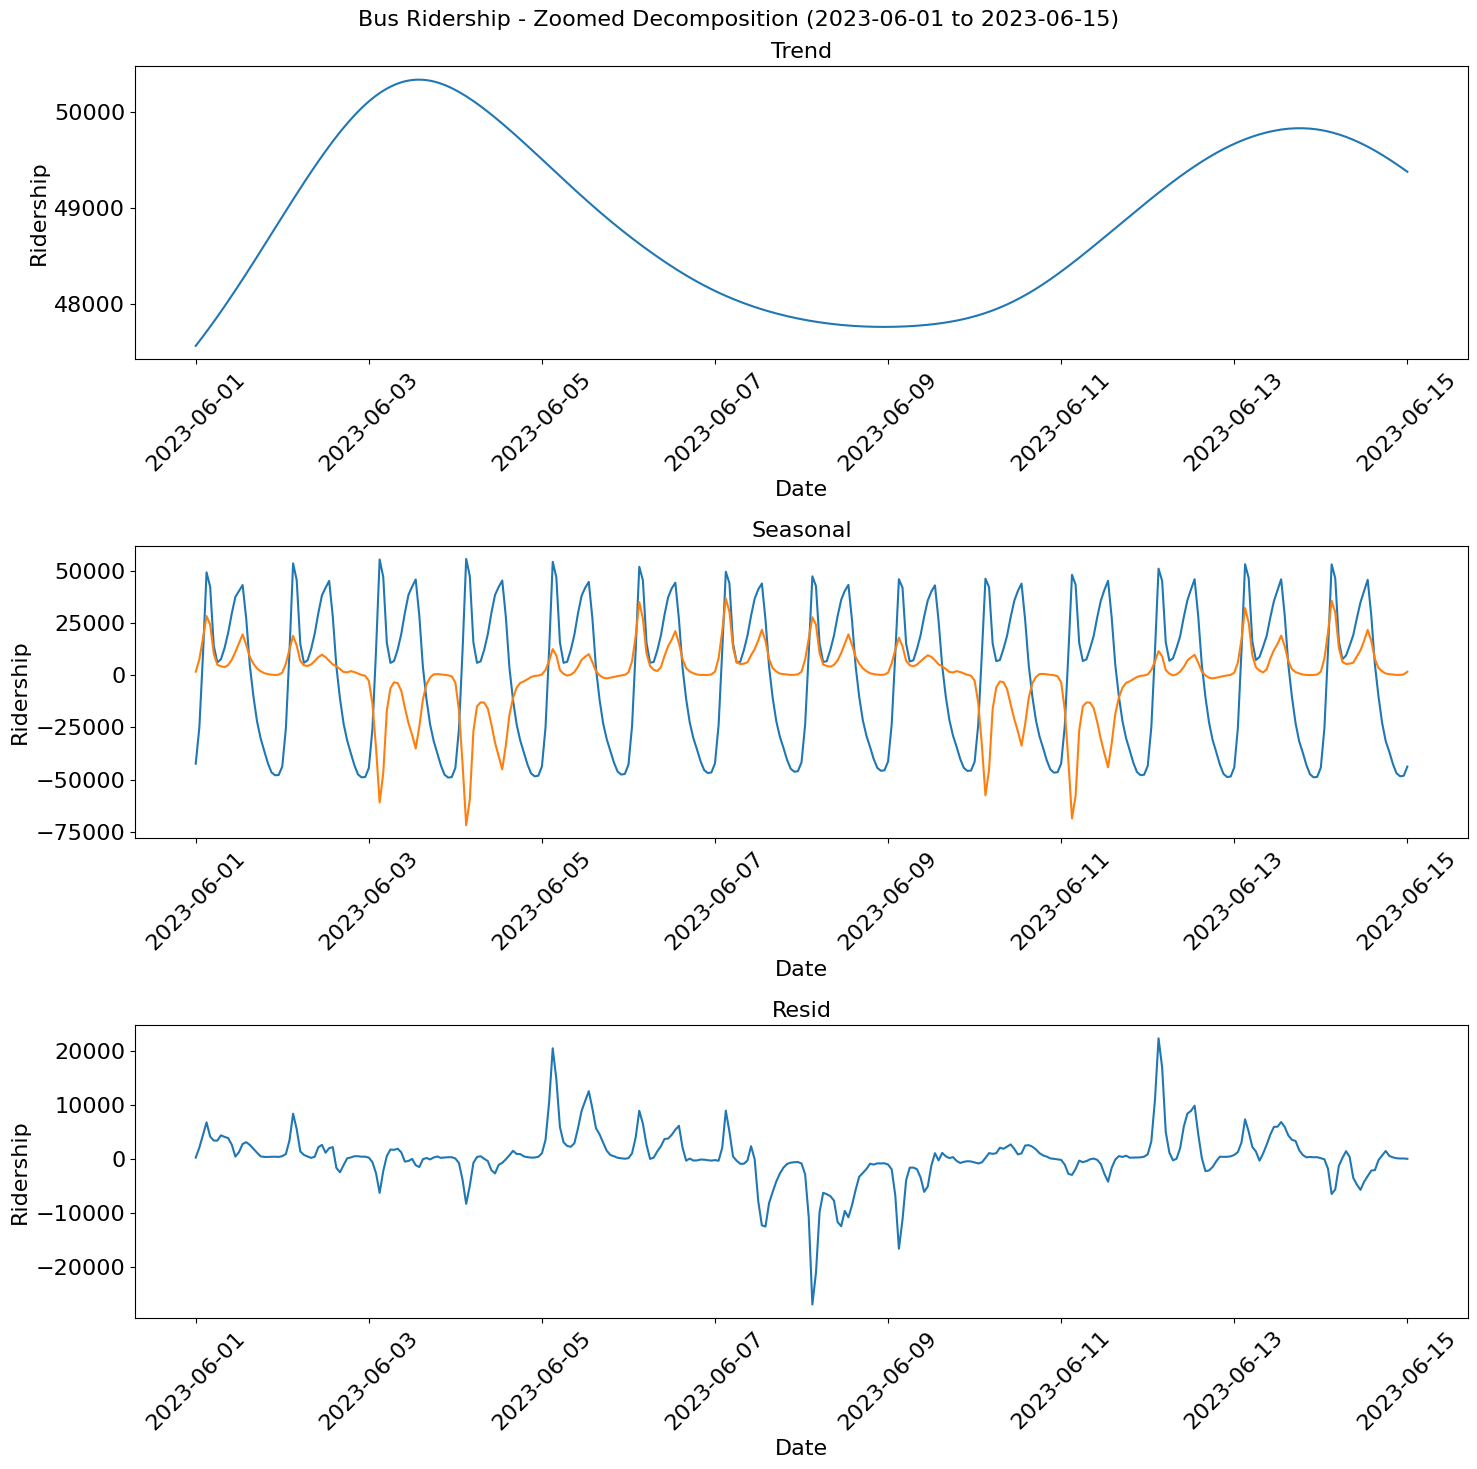

In [5]:
# Zoom in on the trend, seasonality, and residual for bus and subway from June 1 to June 15 in 2023
start_date = '2023-06-01'
end_date = '2023-06-15'

def plot_zoomed_decomposition(decomposition, df, title, start_date, end_date):
    mask = (df['hour'] >= start_date) & (df['hour'] <= end_date)
    zoomed_df = df[mask]
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle(f'{title} - Zoomed Decomposition ({start_date} to {end_date})', fontsize=16)
    
    components = ['trend', 'seasonal', 'resid']
    
    for i, component in enumerate(components):
        axs[i].plot(zoomed_df['hour'], getattr(decomposition, component)[mask])
        axs[i].set_title(component.capitalize(), fontsize=16)
        axs[i].set_xlabel('Date', fontsize=16)
        axs[i].set_ylabel('Ridership', fontsize=16)
        
        # Rotate x-axis labels for better readability
        axs[i].tick_params(axis='x', rotation=45, labelsize=16)
        axs[i].tick_params(axis='y', labelsize=16)
        
    plt.tight_layout()
    plt.show()

# Plot zoomed decomposition for subway data
plot_zoomed_decomposition(subway_decomposition, hourly_subway_df, 'Subway Ridership', start_date, end_date)

# Plot zoomed decomposition for bus data
plot_zoomed_decomposition(bus_decomposition, hourly_bus_df, 'Bus Ridership', start_date, end_date)


Read in weather data

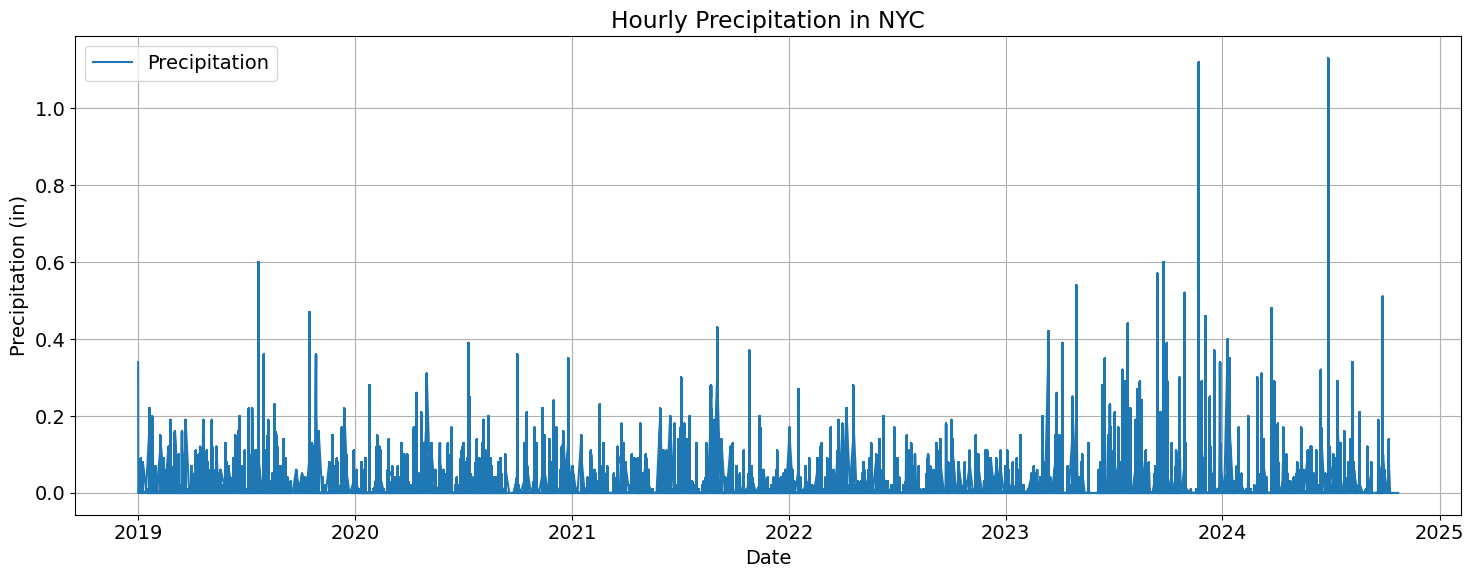

Number of hours in weather data: 355992
Number of hours in subway data after cutoff: 37909
Number of hours in bus data after cutoff: 23969


In [6]:
# Plot the precipitation weather data over time
plt.figure(figsize=(15, 6))
plt.plot(weather_df['time'], weather_df['Precipitation (in)'], label='Precipitation')
plt.title('Hourly Precipitation in NYC')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some information about the data
print(f"Number of hours in weather data: {len(weather_df)}")
print(f"Number of hours in subway data after cutoff: {len(hourly_subway_df)}")
print(f"Number of hours in bus data after cutoff: {len(hourly_bus_df)}")

In [7]:
combined_df = get_combined_residuals_df(hourly_subway_df, hourly_bus_df, weather_df, subway_decomposition, bus_decomposition)

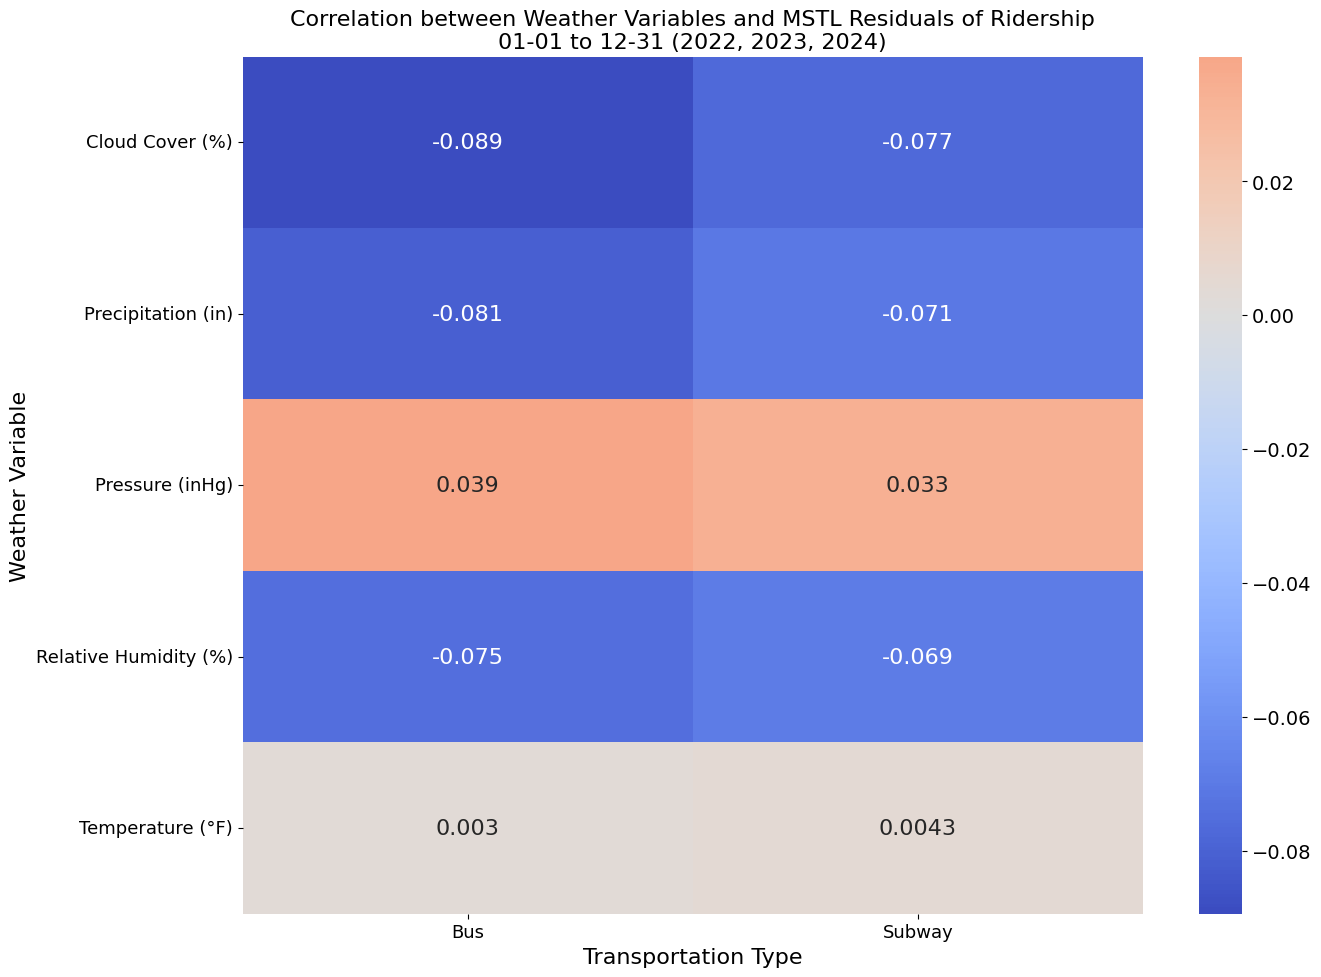

In [8]:
start_date = '01-01'
end_date = '12-31'
# start_date = '12-01'
# end_date = '02-28'
# hours = (8, 12)
is_weekend = None
hours = None

result_df = analyze_weather_impact(combined_df, lag=0, start_date=start_date, end_date=end_date, 
                                   hour_range=hours, is_weekend=is_weekend, plot=True)


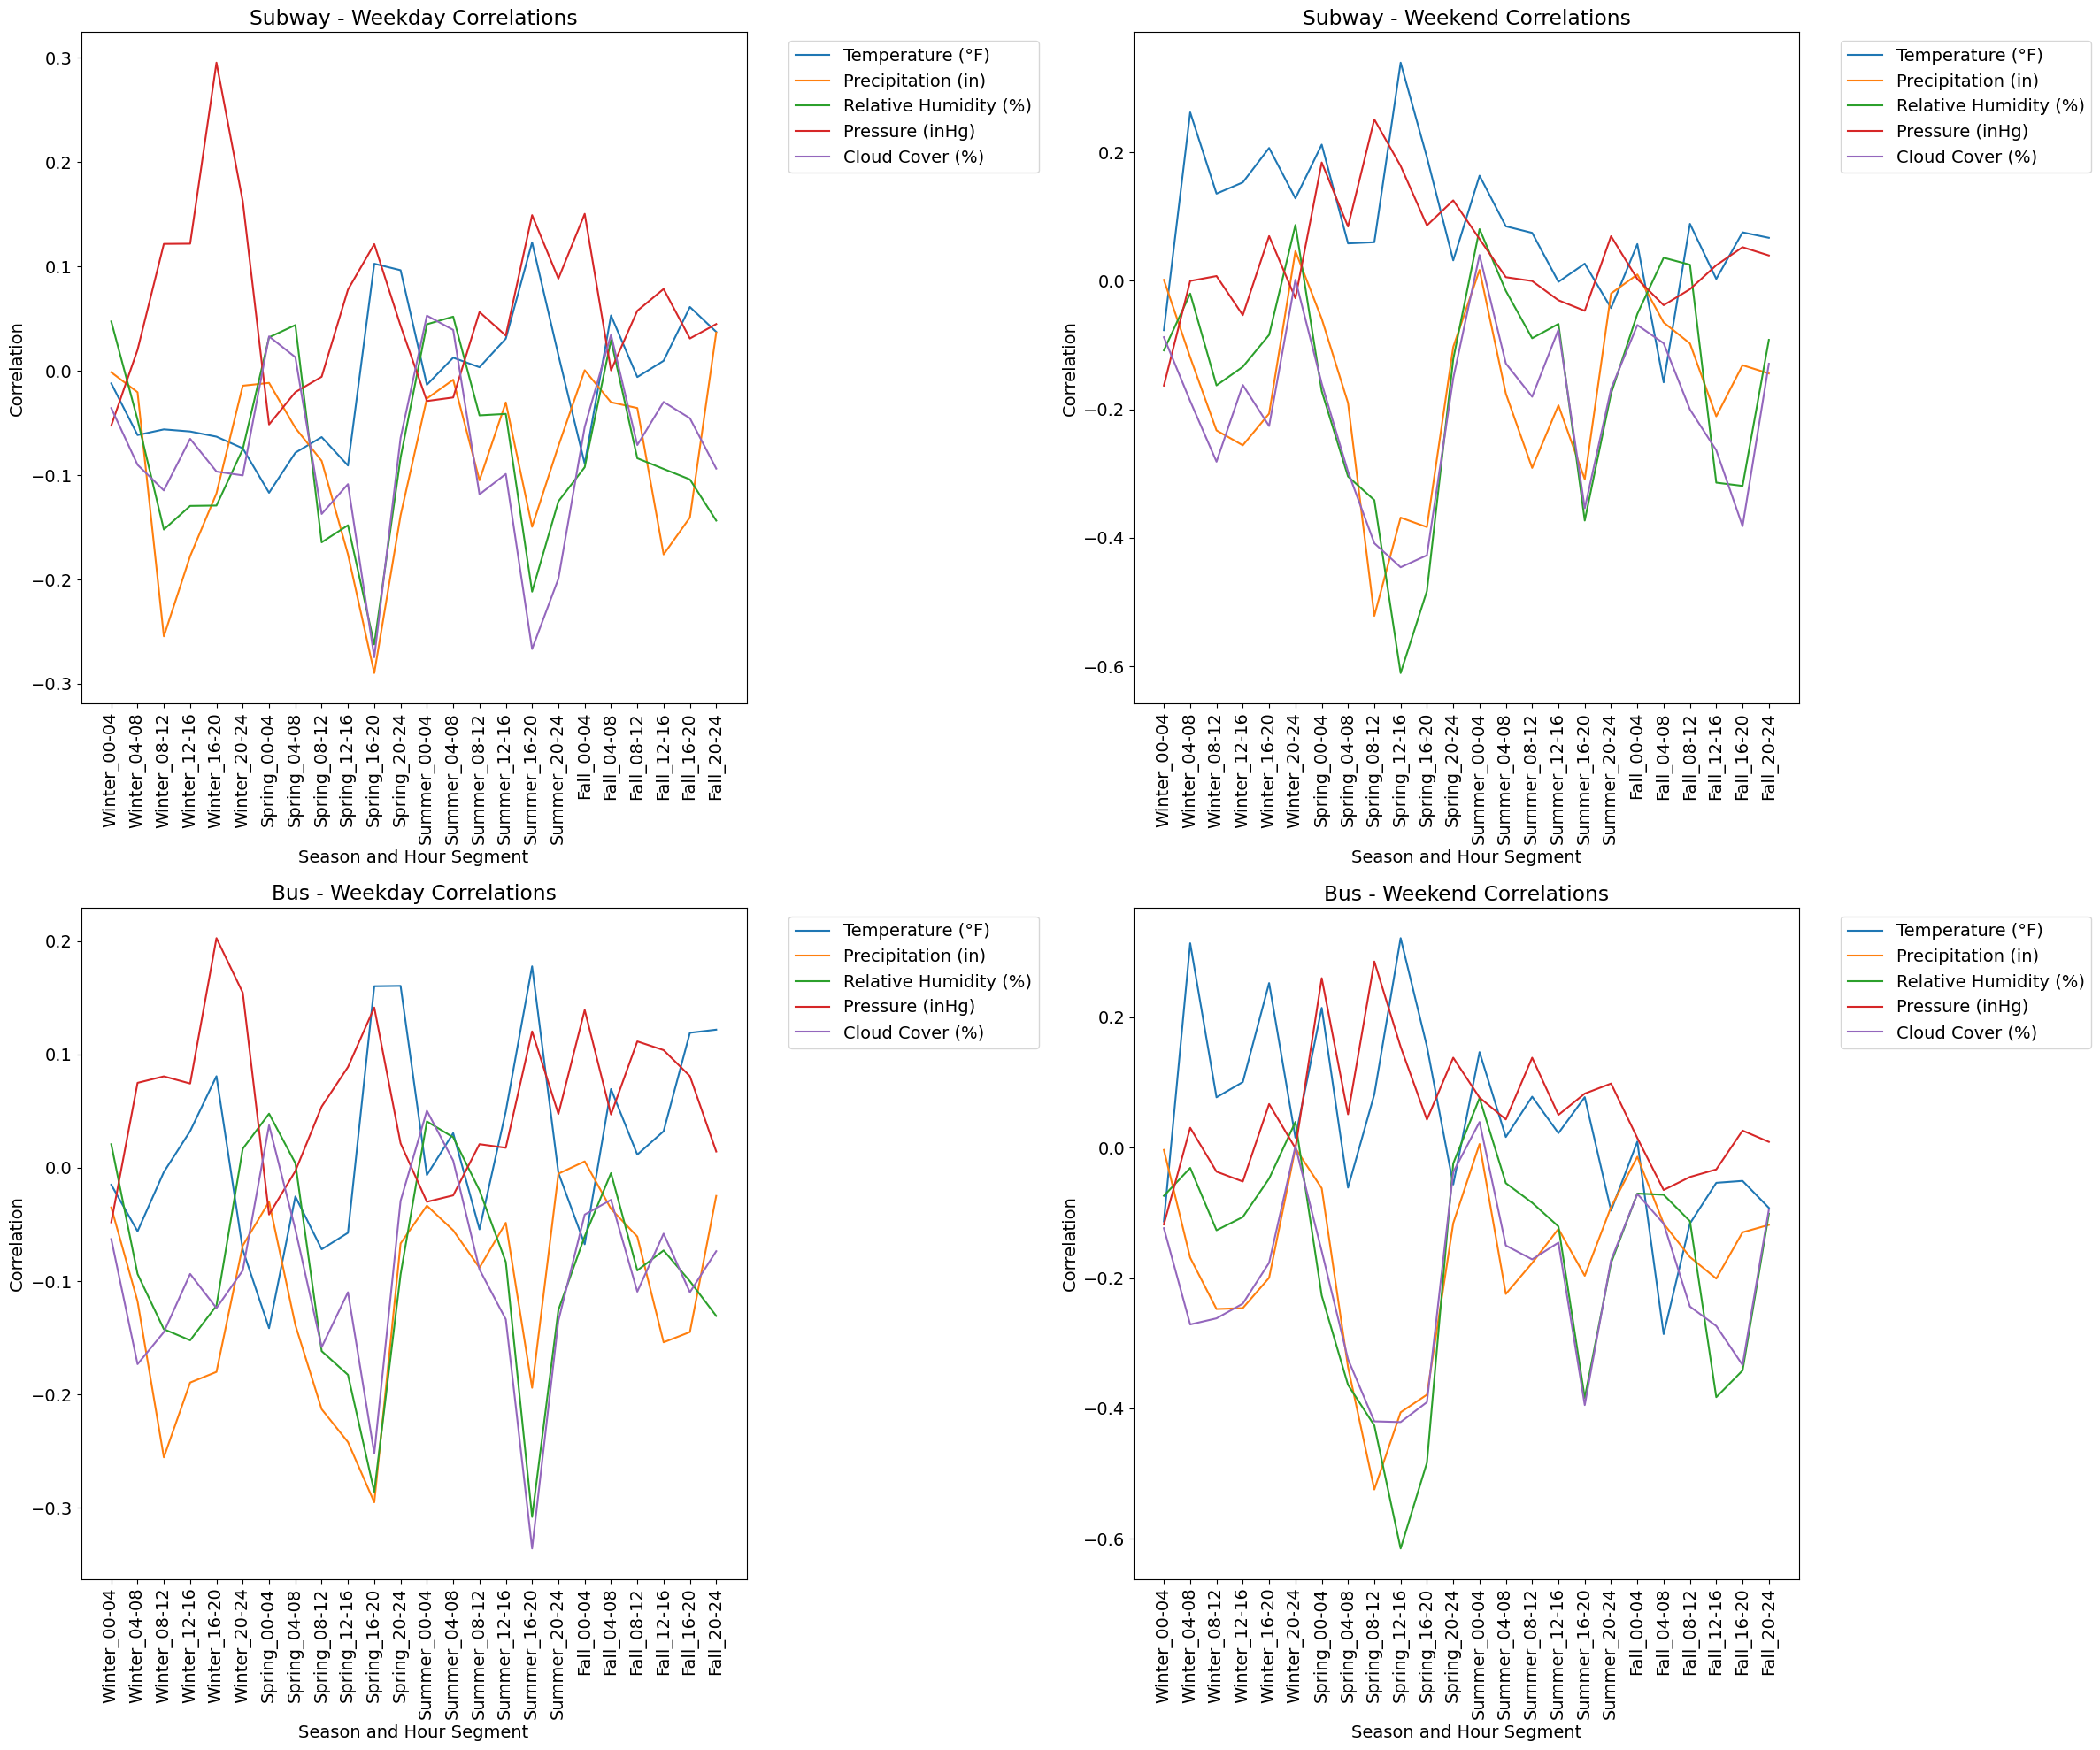

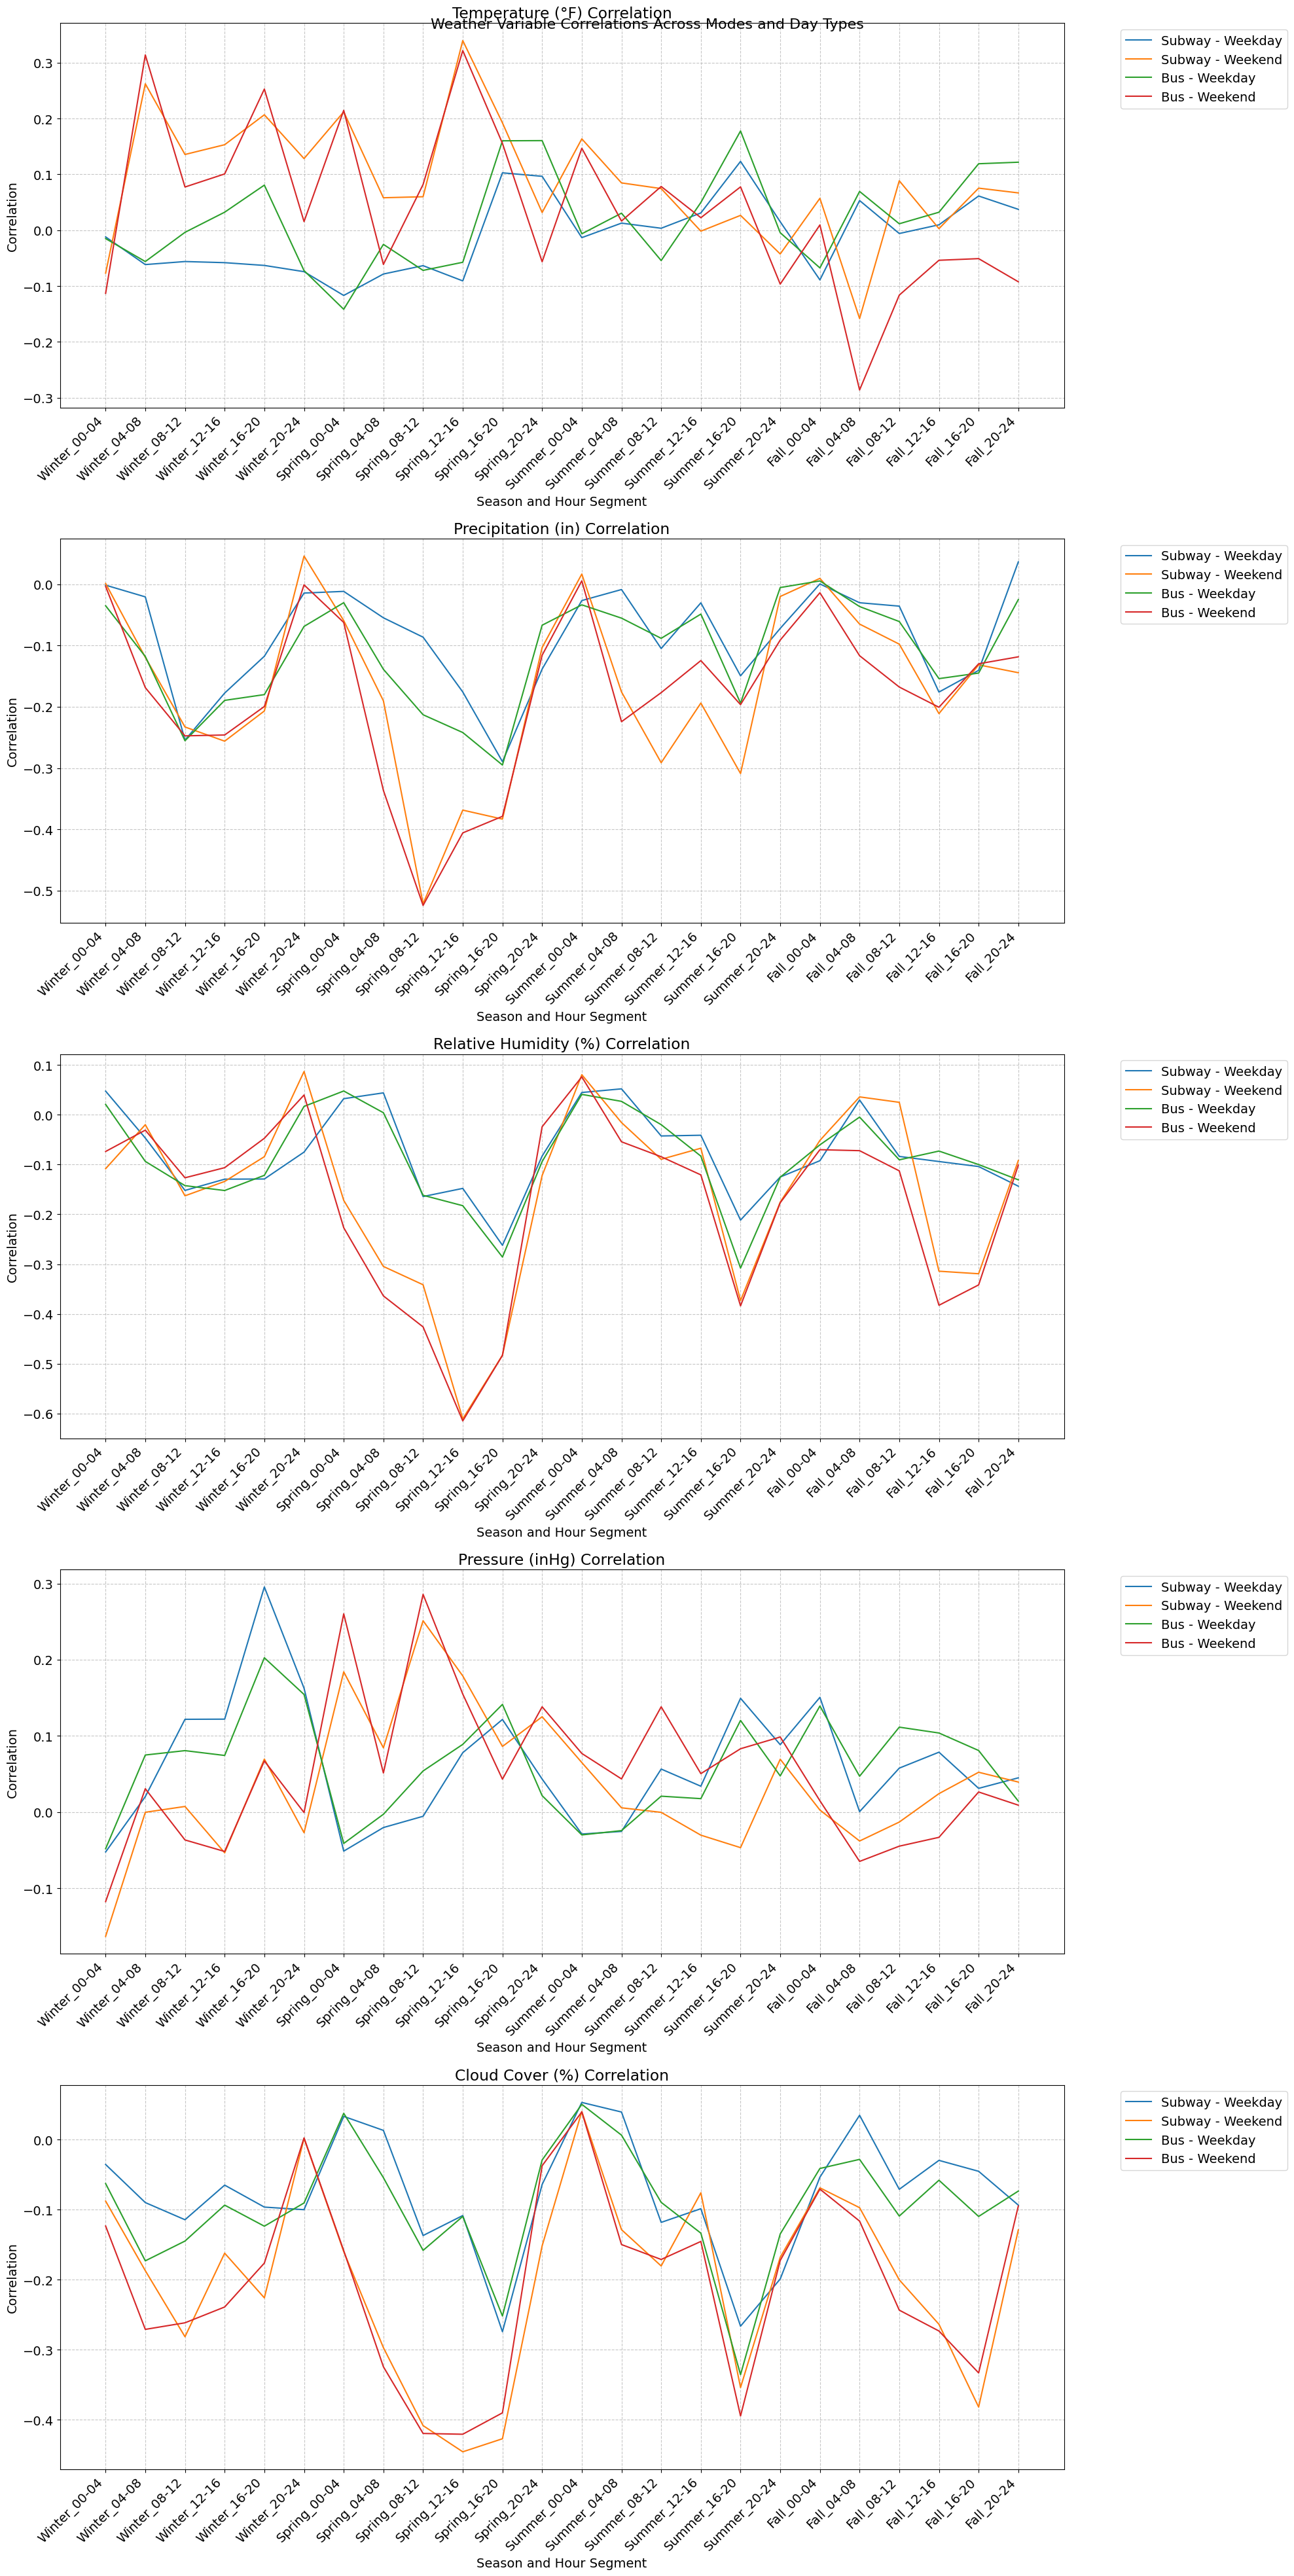

In [9]:
# Calculate correlations
correlations_df = analyze_all_conditions(combined_df, lag=0)

# Plotting
plt.figure(figsize=(24, 20))
for mode in ['Subway', 'Bus']:
    for i, day_type in enumerate(['Weekday', 'Weekend']):
        plt.subplot(2, 2, i + 1 if mode == 'Subway' else i + 3)
        data = correlations_df[(correlations_df['Transportation Type'] == mode) & (correlations_df['Day Type'] == day_type)]
        sns.lineplot(data=data, x='Season_Hour', y='Correlation', hue='Weather Variable', 
                     markers=True, dashes=False, errorbar=None)
        plt.title(f'{mode} - {day_type} Correlations')
        plt.xlabel('Season and Hour Segment')
        plt.ylabel('Correlation')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Get unique variables
variables = correlations_df['Weather Variable'].unique()

# Set up the plot
fig, axs = plt.subplots(len(variables), 1, figsize=(20, 8*len(variables)))
fig.suptitle('Weather Variable Correlations Across Modes and Day Types', fontsize=16)

# Plot each variable
for i, variable in enumerate(variables):
    ax = axs[i] if len(variables) > 1 else axs
    
    for mode in ['Subway', 'Bus']:
        for day_type in ['Weekday', 'Weekend']:
            data = correlations_df[(correlations_df['Transportation Type'] == mode) & 
                                   (correlations_df['Day Type'] == day_type) & 
                                   (correlations_df['Weather Variable'] == variable)]
            
            sns.lineplot(data=data, x='Season_Hour', y='Correlation', 
                         label=f'{mode} - {day_type}',
                         markers=True, dashes=False, ax=ax)
    
    ax.set_title(f'{variable} Correlation')
    ax.set_xlabel('Season and Hour Segment')
    ax.set_ylabel('Correlation')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    x_ticks = np.arange(len(ax.get_xticklabels()))
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)
    
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


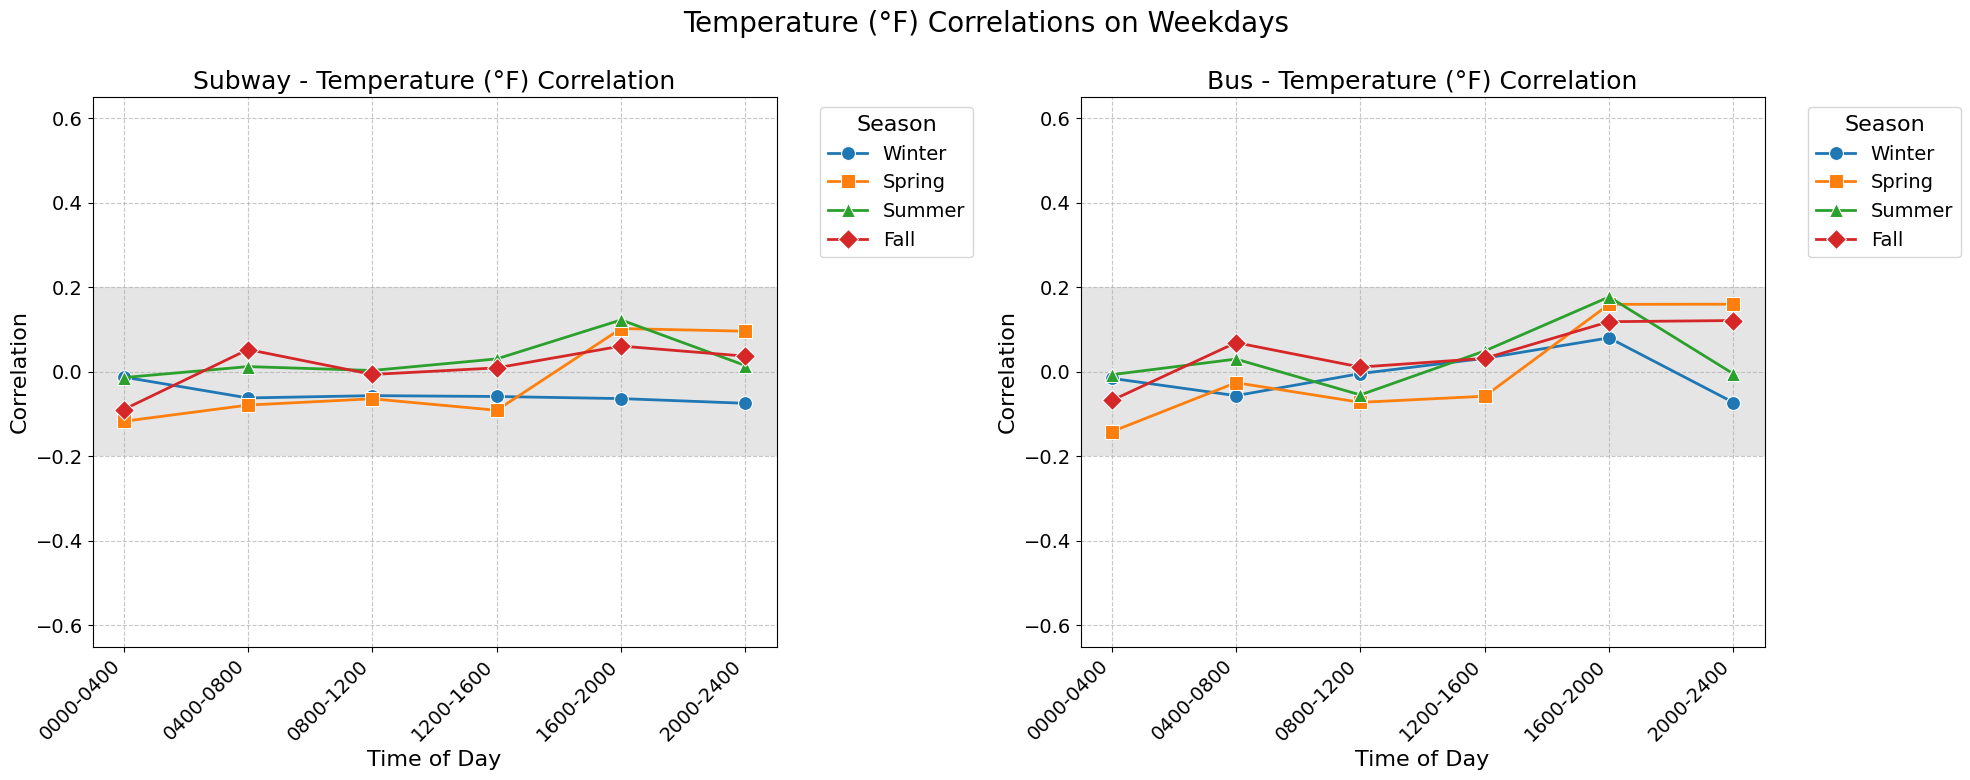

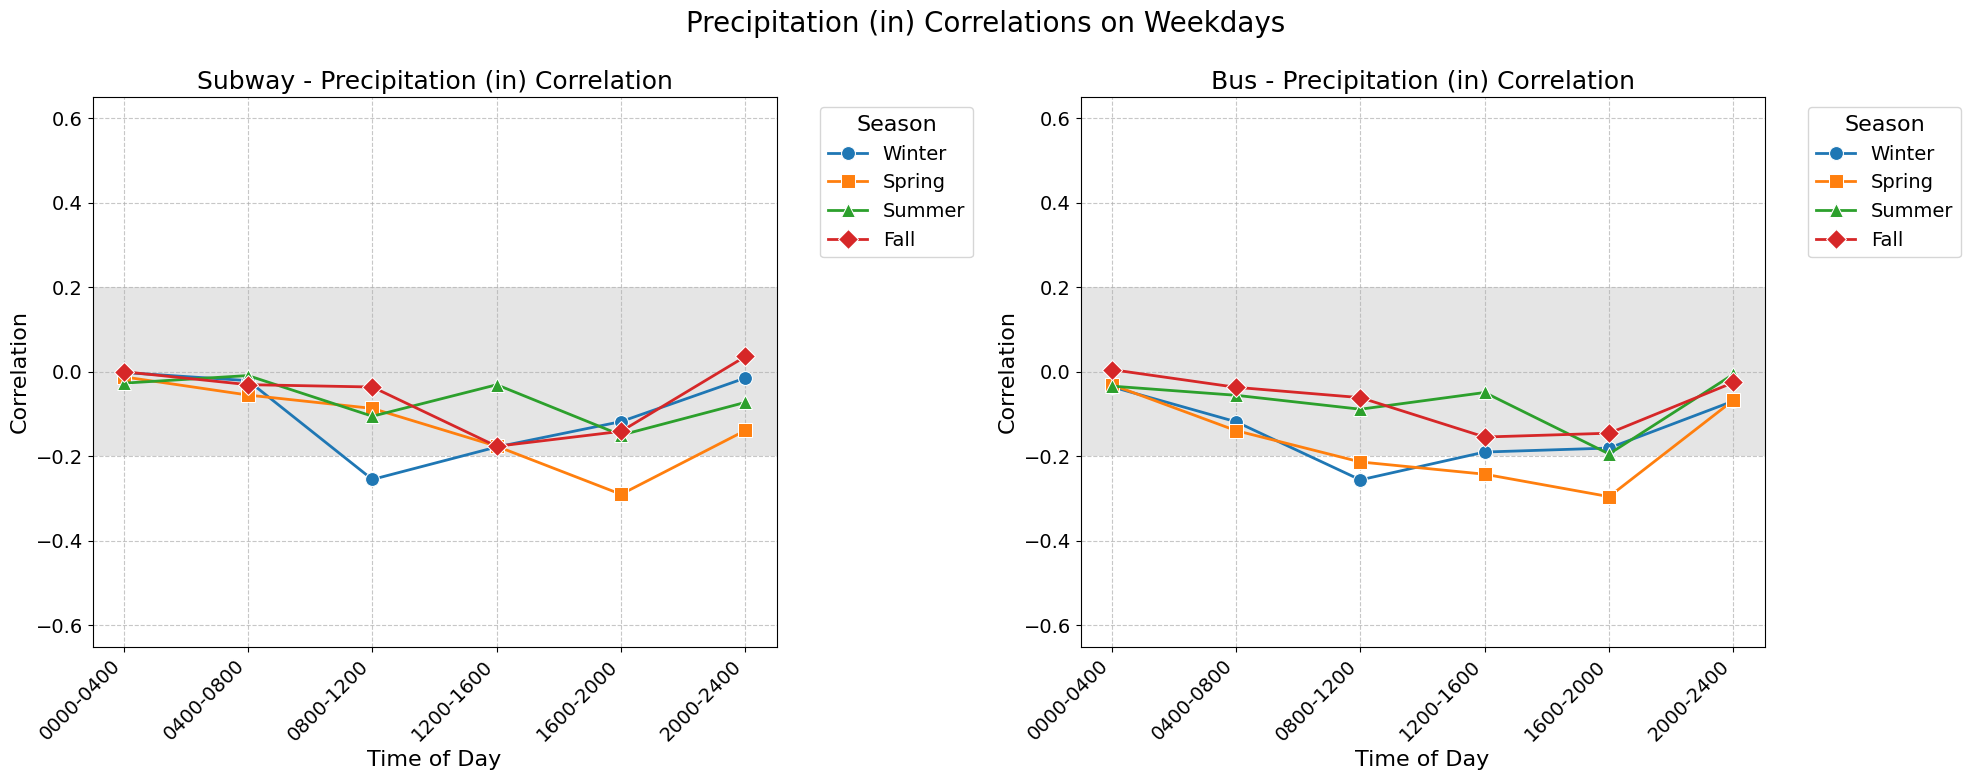

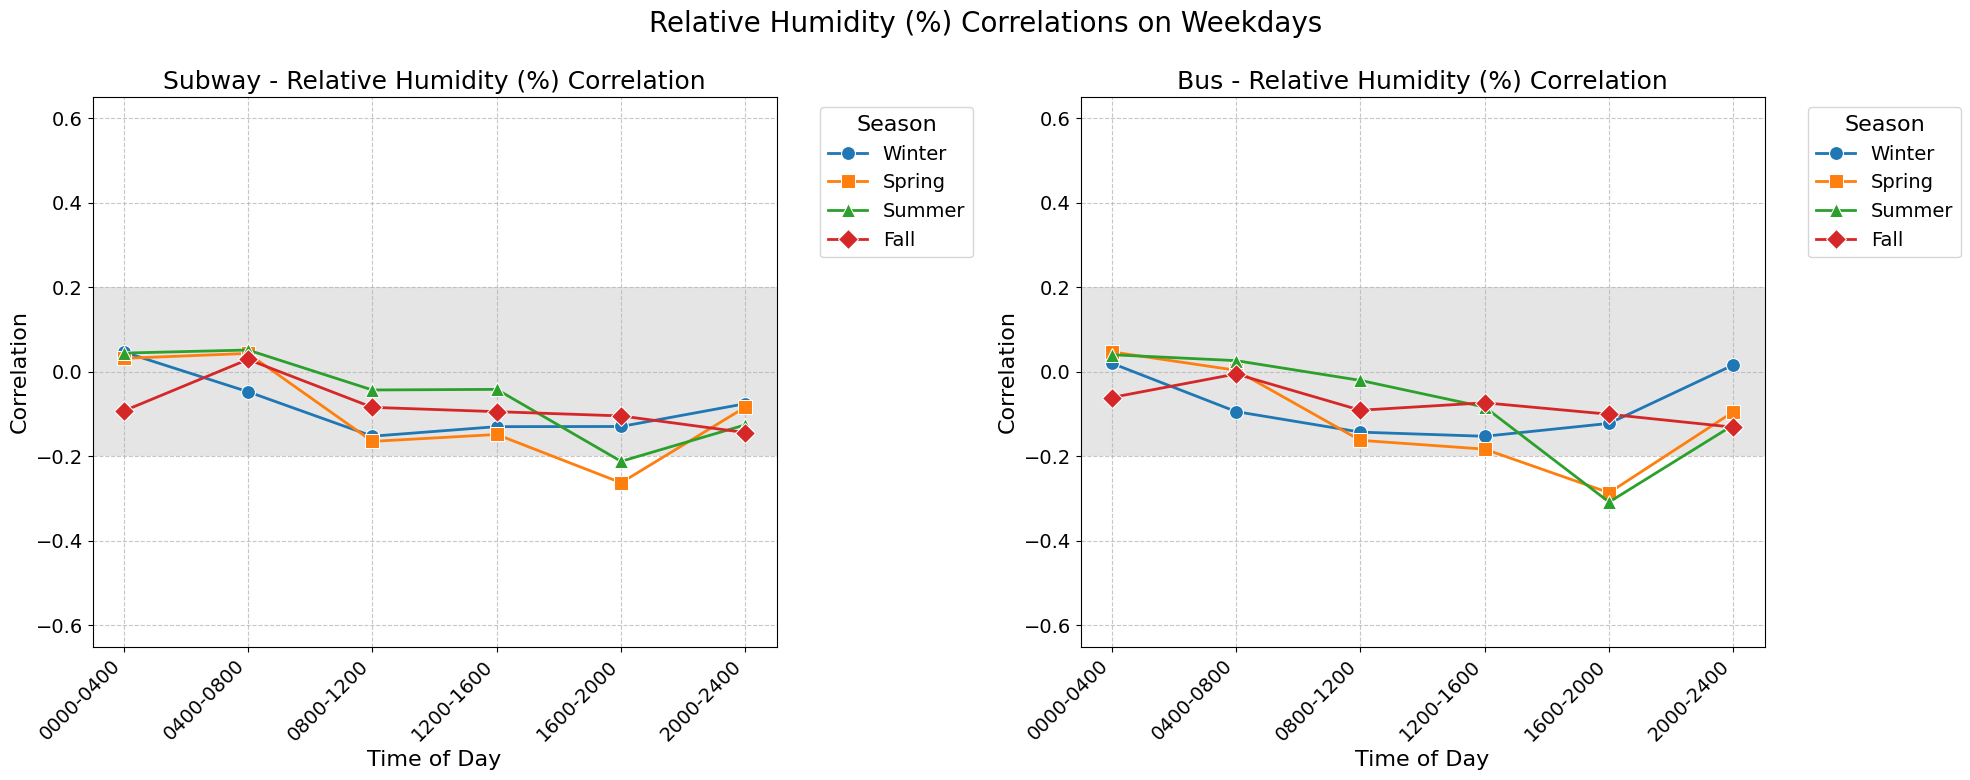

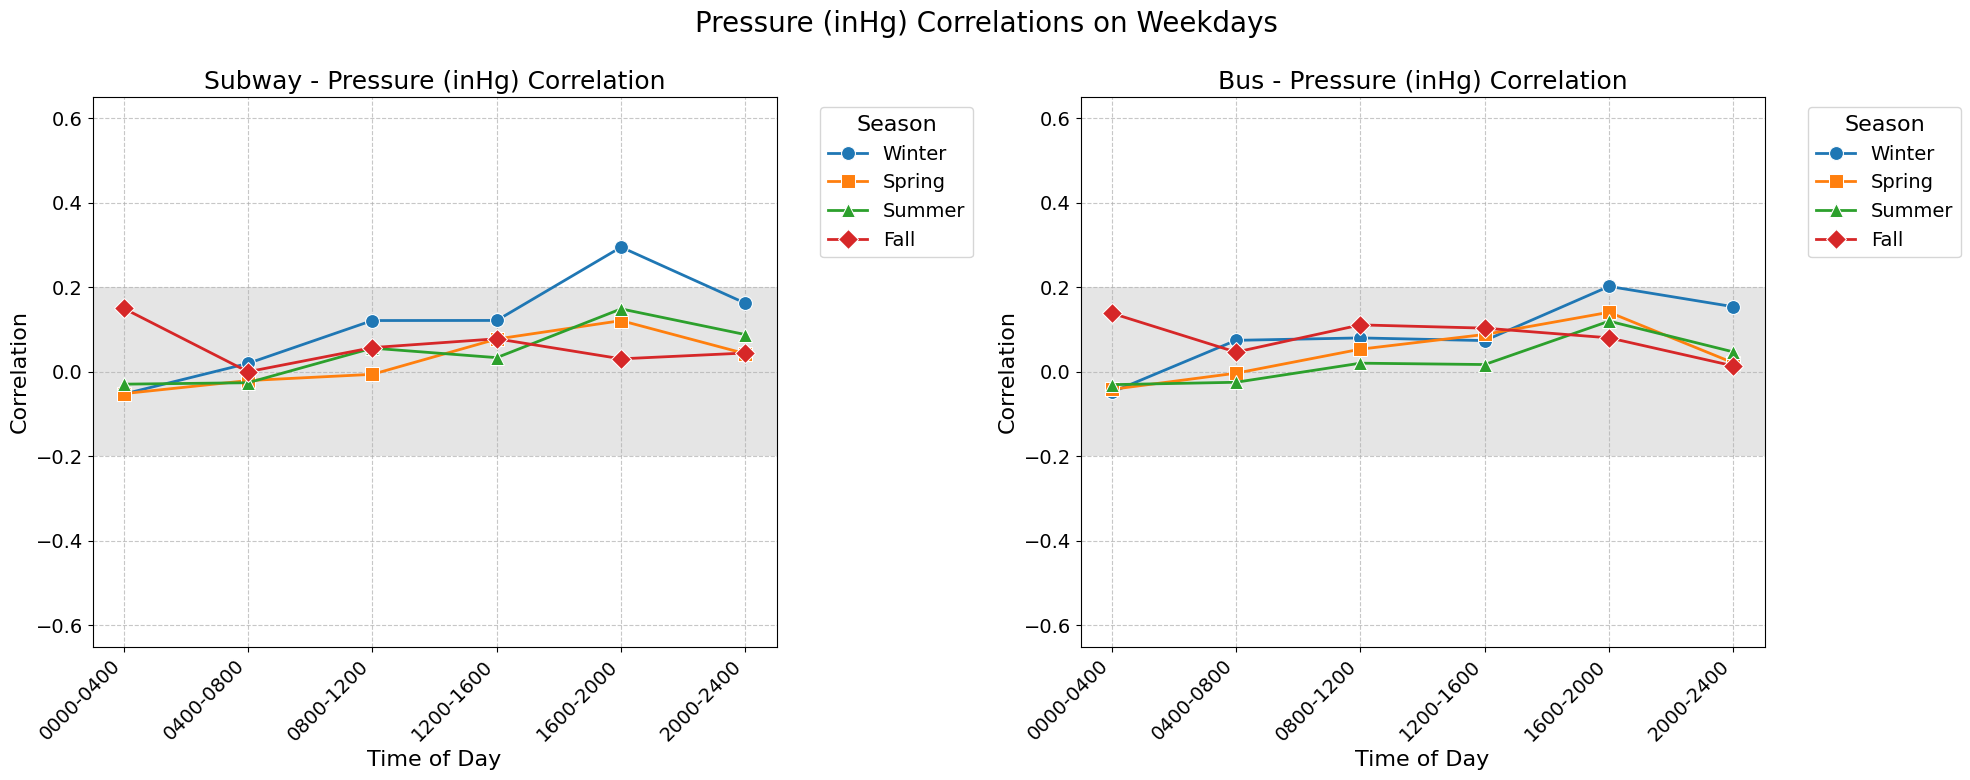

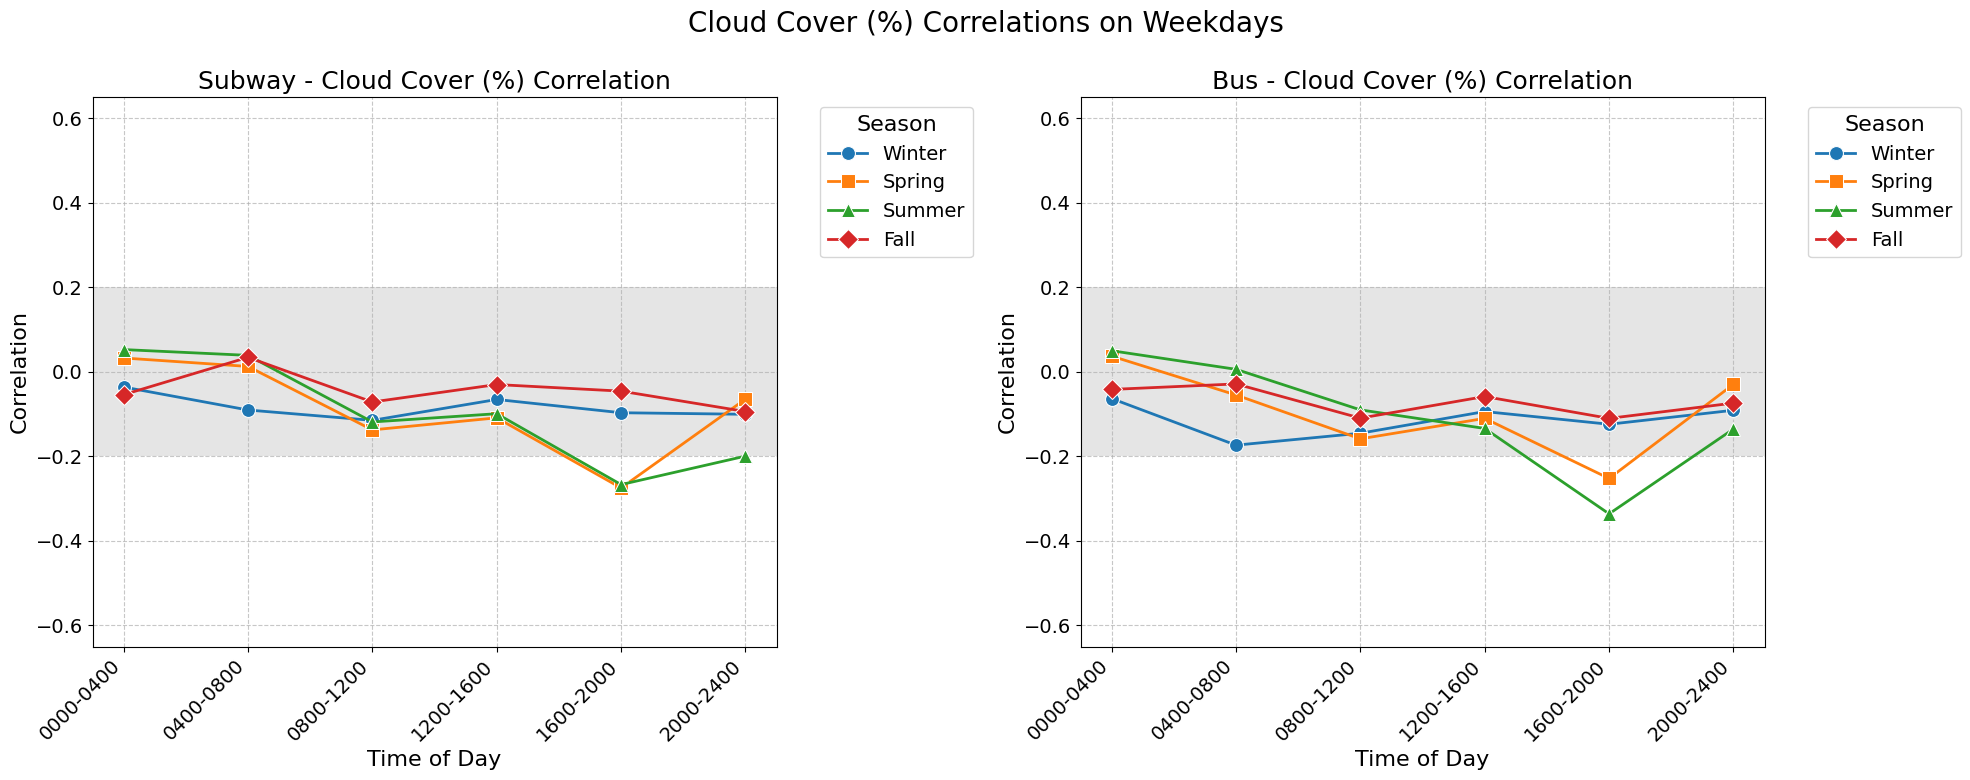

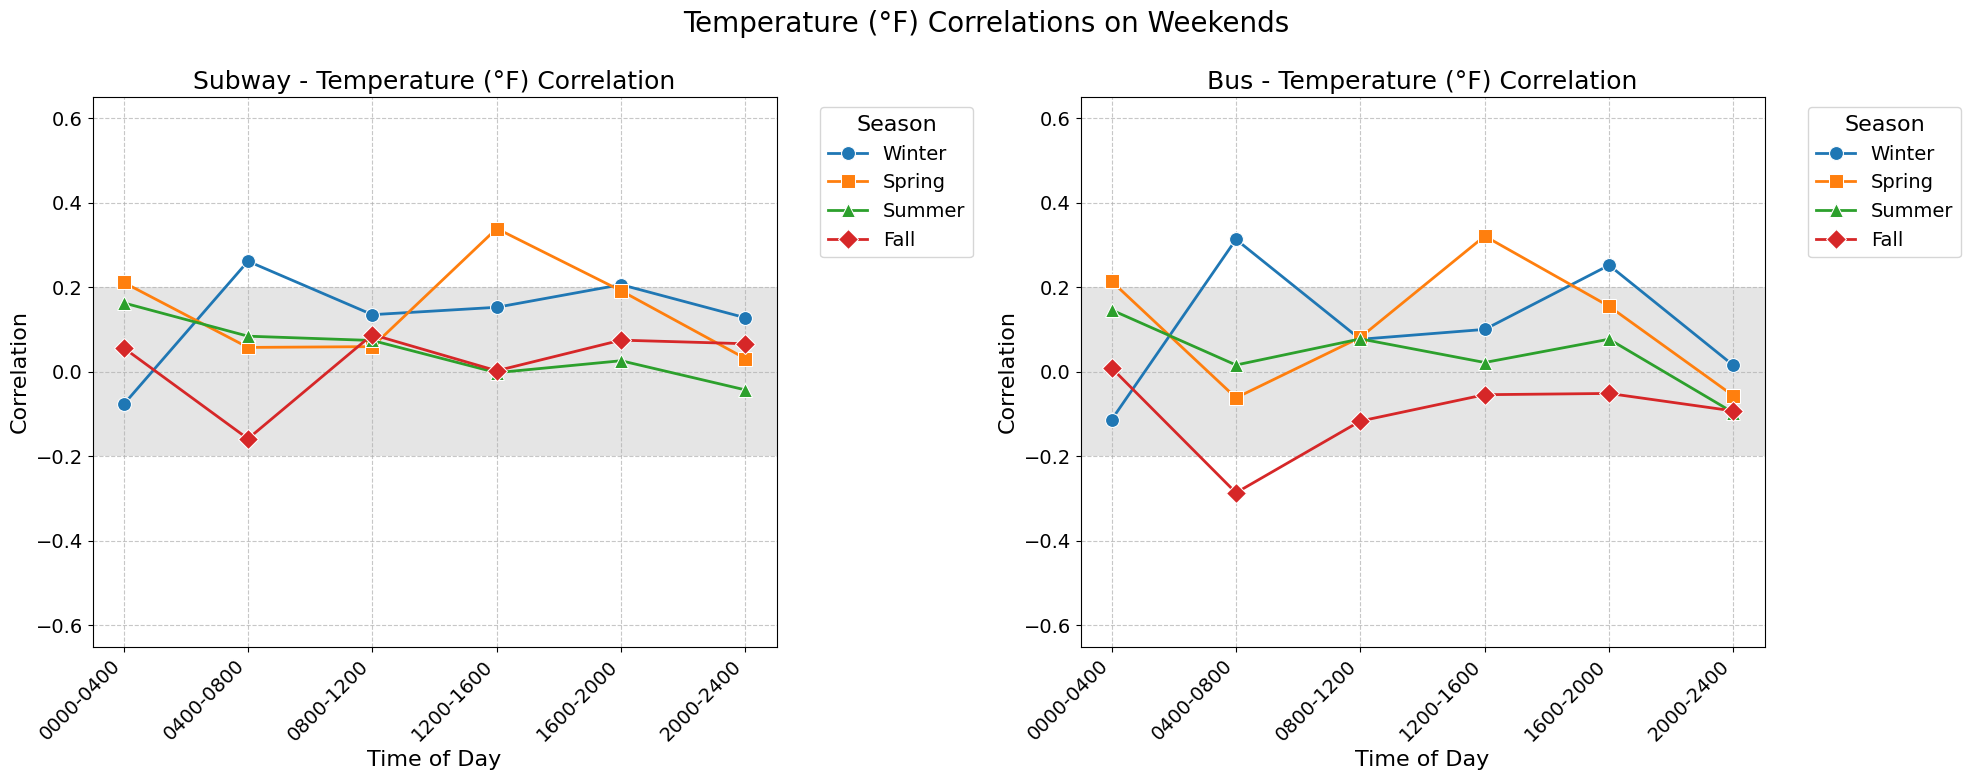

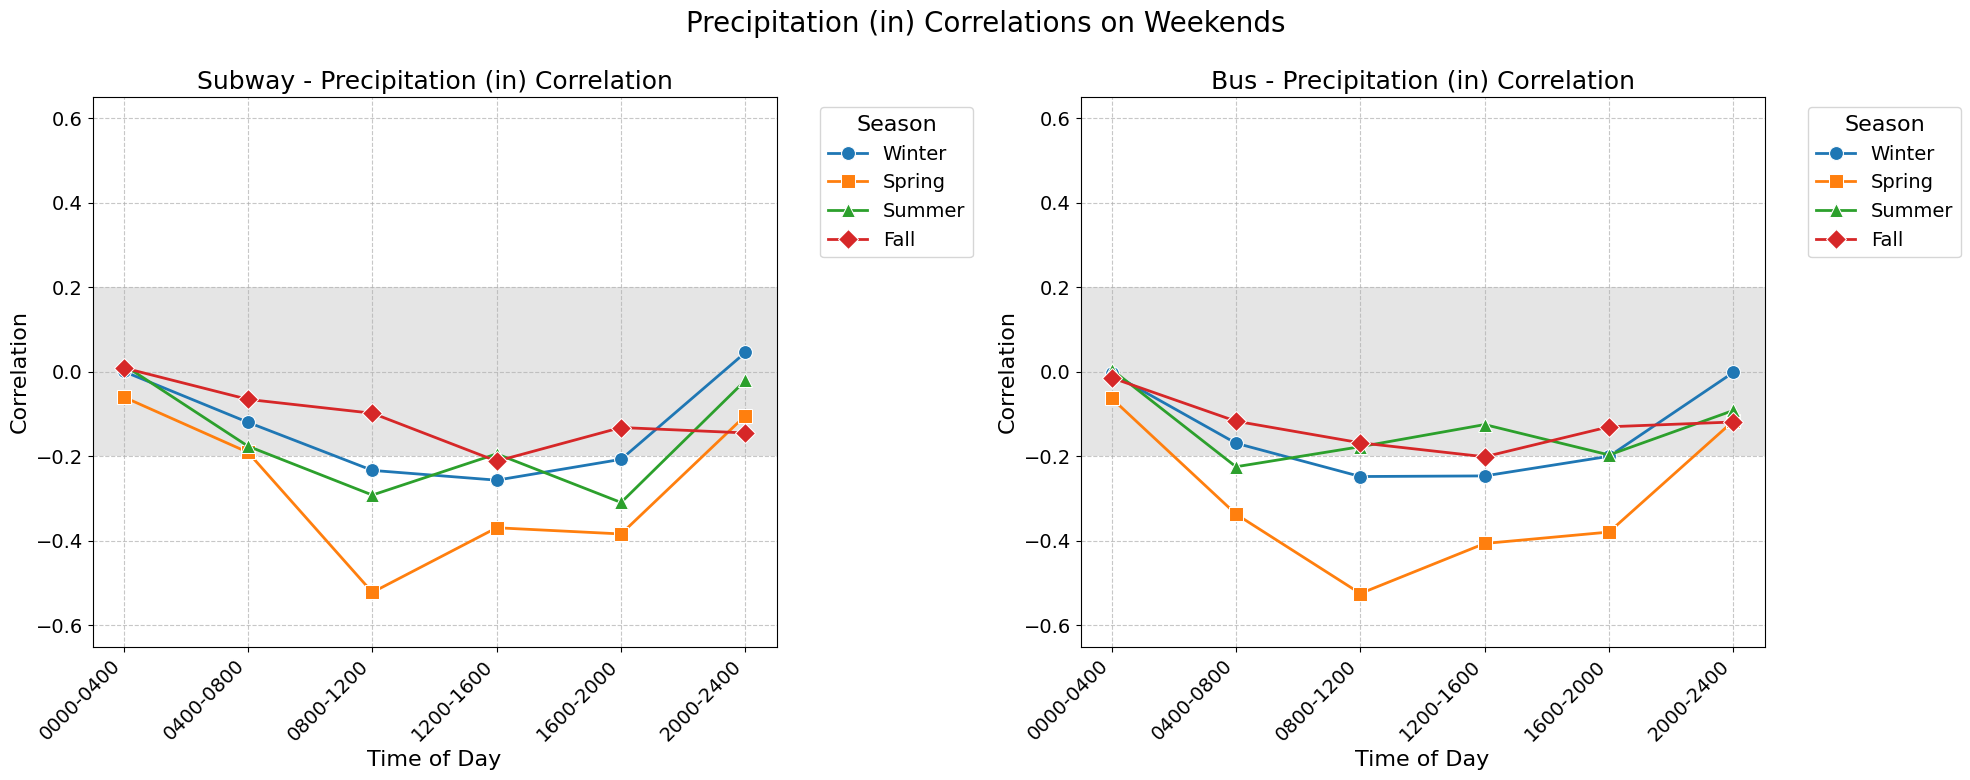

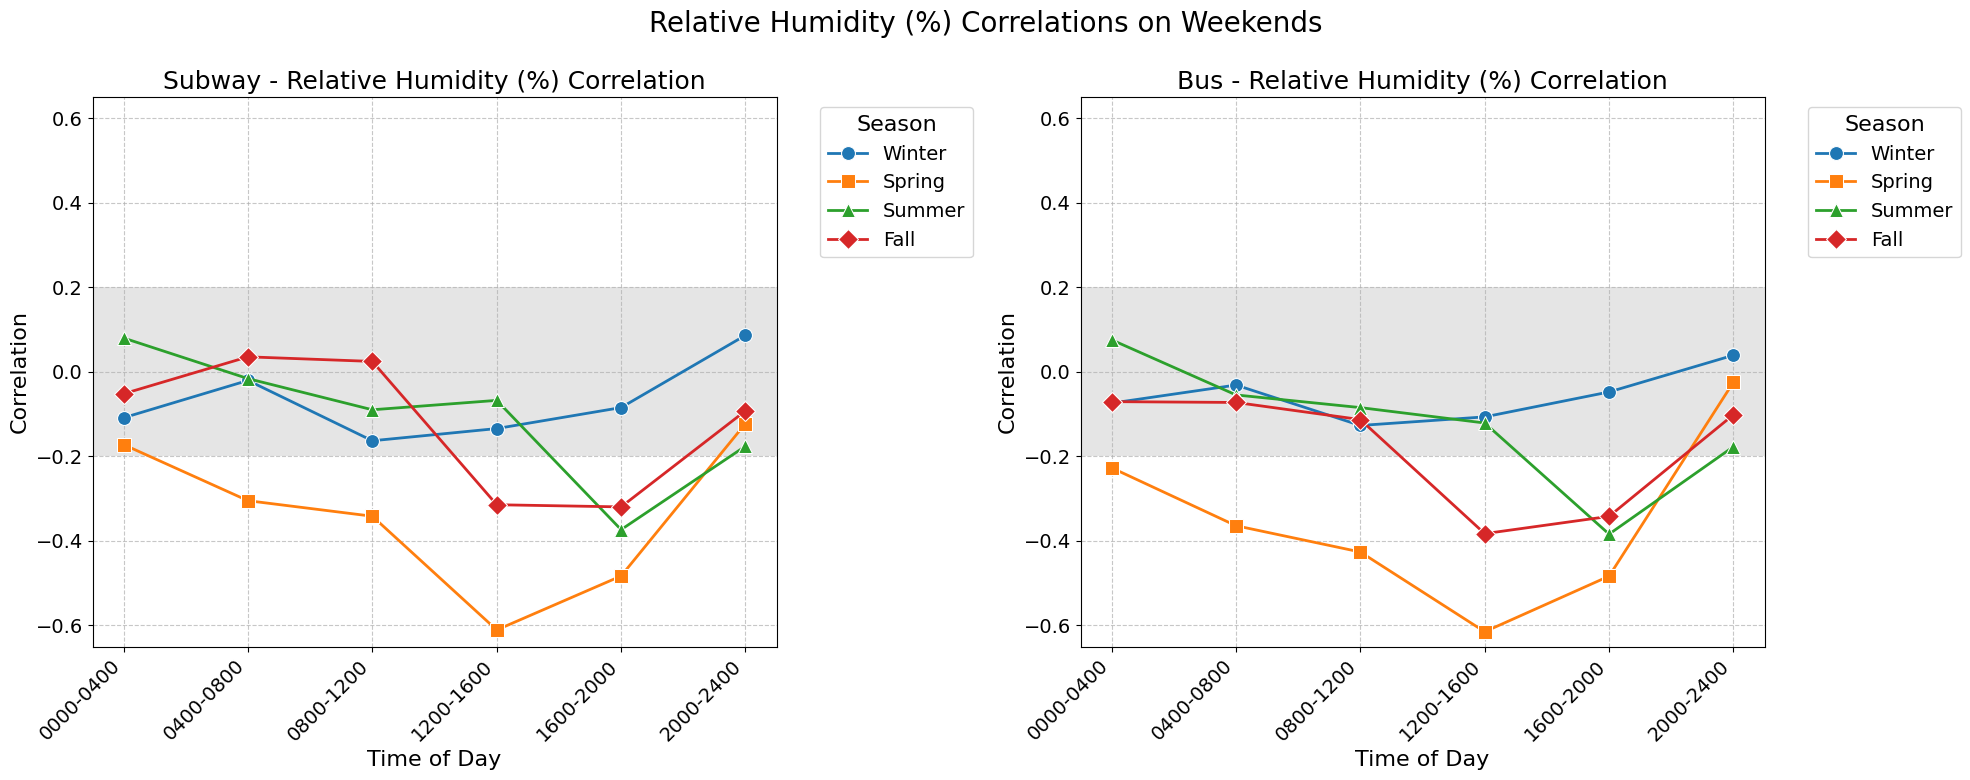

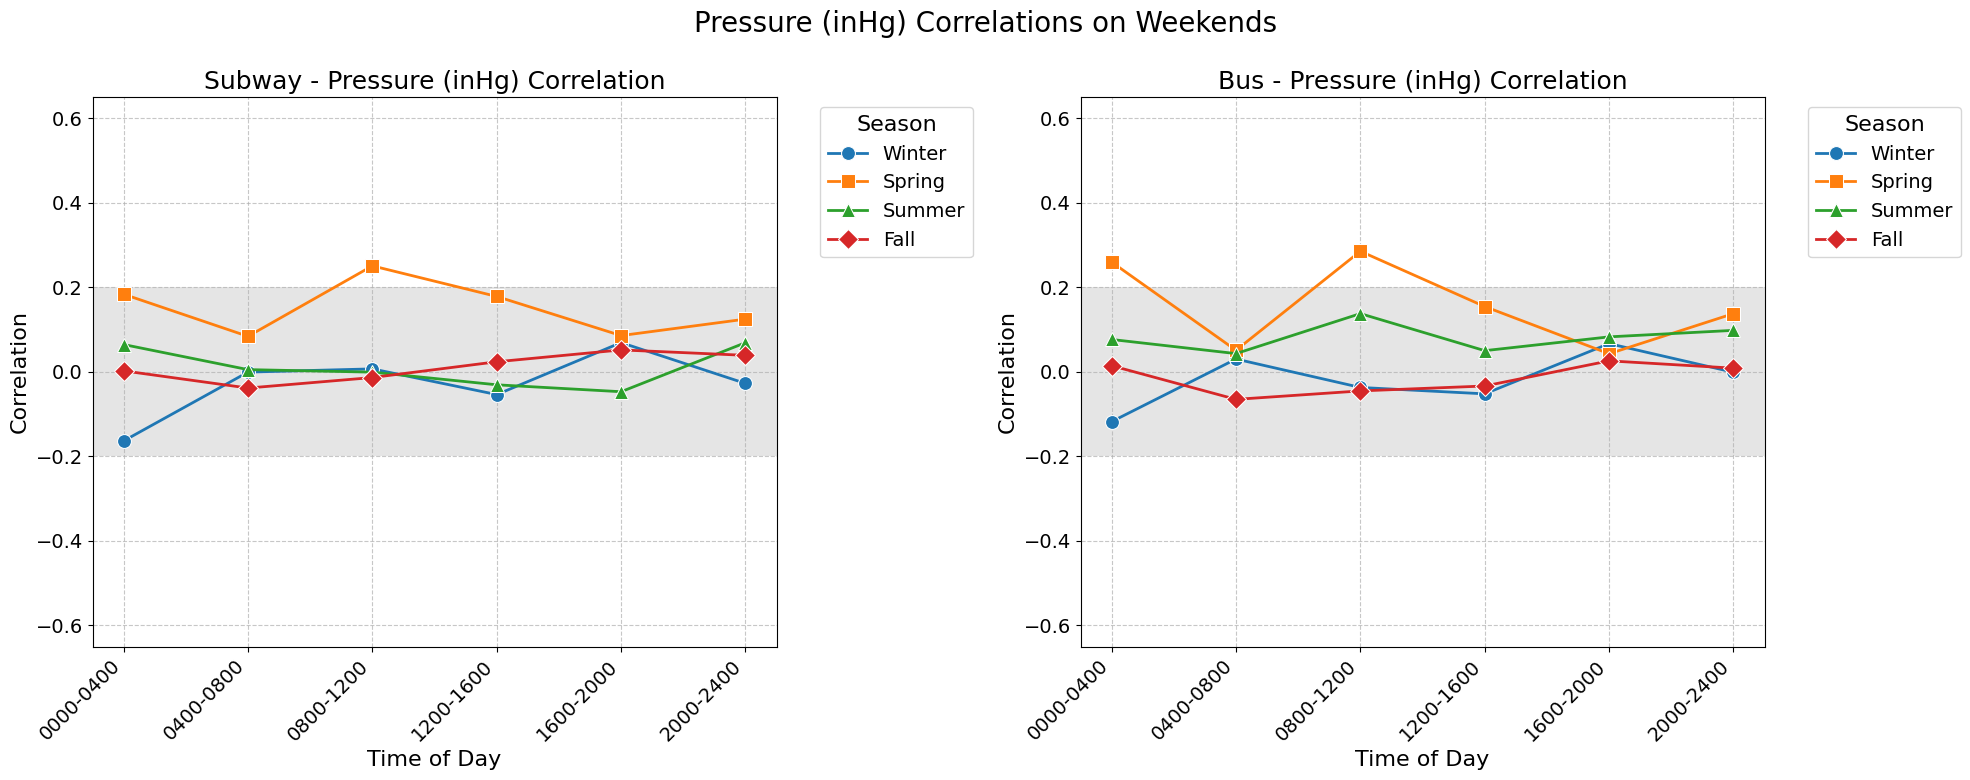

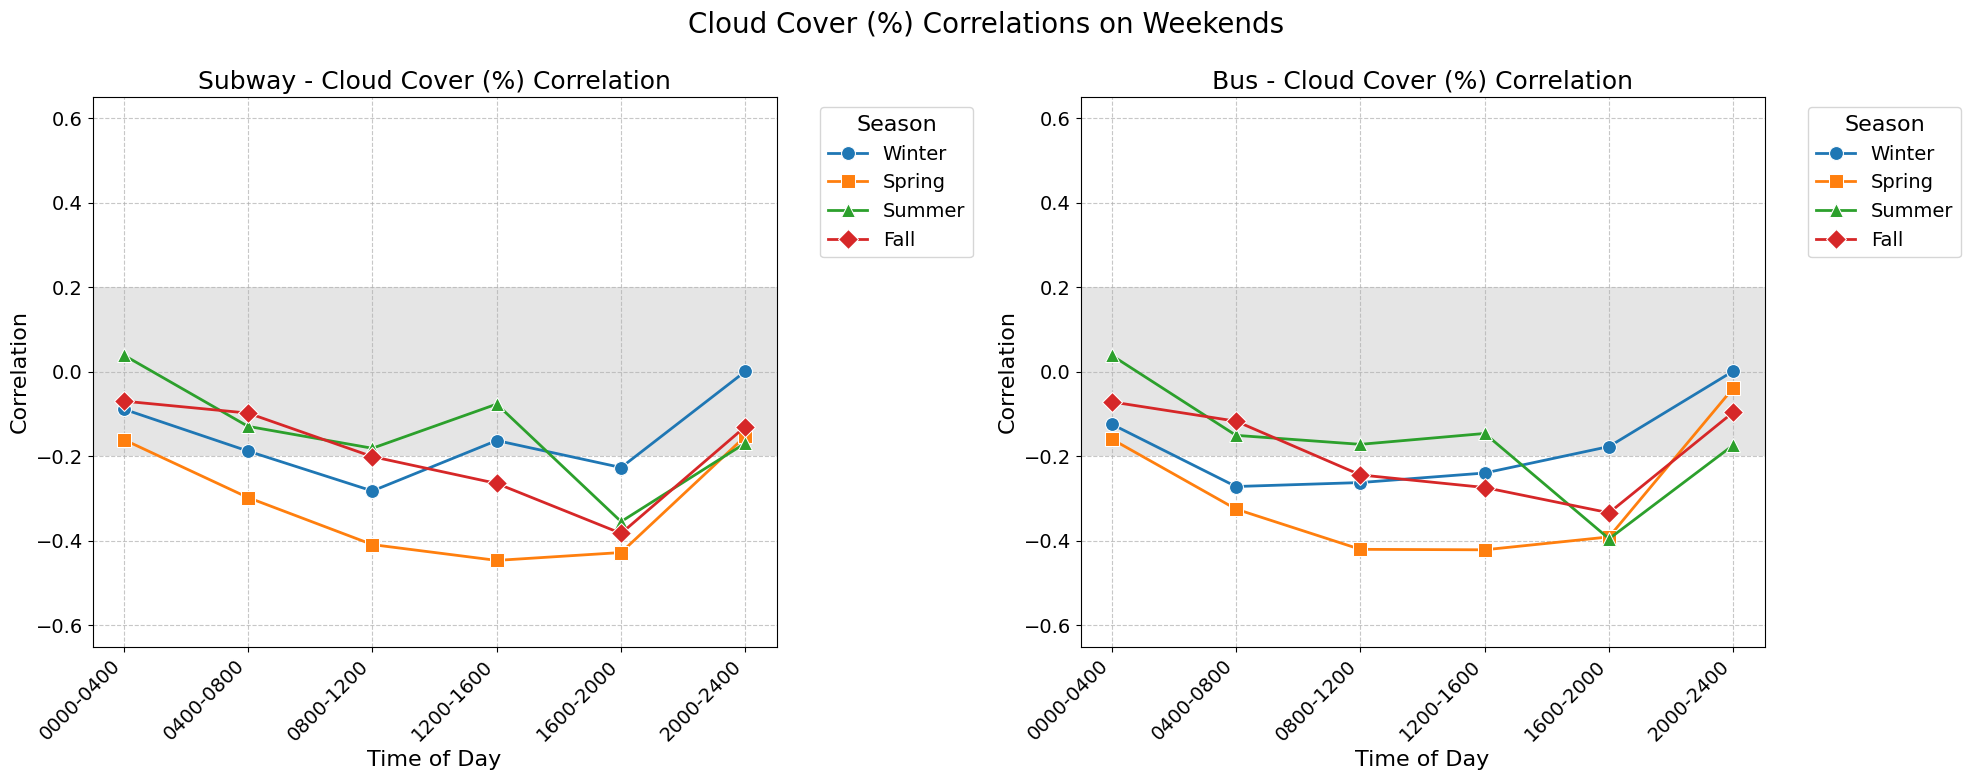

In [10]:
# Increase the default font size for all text elements
plt.rcParams.update({'font.size': 16})

# Calculate correlations
correlations_df = analyze_all_conditions(combined_df, lag=0)

# Get unique variables
variables = correlations_df['Weather Variable'].unique()

# Define markers for each season
season_markers = {'Winter': 'o', 'Spring': 's', 'Summer': '^', 'Fall': 'D'}

# Function to convert hour segment to military time
def to_military_time(hour_segment):
    start, end = map(int, hour_segment.split('-'))
    return f'{start:02d}00-{end:02d}00'

# Plot for both weekdays and weekends
for day_type in ['Weekday', 'Weekend']:
    day_type_correlations = correlations_df[correlations_df['Day Type'] == day_type]
    
    for variable in variables:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f'{variable} Correlations on {day_type}s', fontsize=20)
        
        for mode, ax in zip(['Subway', 'Bus'], [ax1, ax2]):
            data = day_type_correlations[(day_type_correlations['Transportation Type'] == mode) & 
                                        (day_type_correlations['Weather Variable'] == variable)]
            
            # Add shaded region
            ax.axhspan(-0.2, 0.2, facecolor='gray', alpha=0.2)
            
            for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                season_data = data[data['Season'] == season]
                
                sns.lineplot(data=season_data, x='Hour Segment', y='Correlation', 
                             label=season, marker=season_markers[season], 
                             markersize=10, linewidth=2, ax=ax)
            
            ax.set_title(f'{mode} - {variable} Correlation', fontsize=18)
            ax.set_xlabel('Time of Day', fontsize=16)
            ax.set_ylabel('Correlation', fontsize=16)
            ax.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)
            
            # Convert x-axis labels to military time and set fixed locations
            x_ticks = np.arange(len(data['Hour Segment'].unique()))
            x_labels = [to_military_time(label) for label in data['Hour Segment'].unique()]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)
            
            ax.tick_params(axis='both', which='major', labelsize=14)
            
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Set y-axis limits to ensure the shaded region is visible
            ax.set_ylim(-0.65, 0.65)

        plt.tight_layout()
        plt.show()


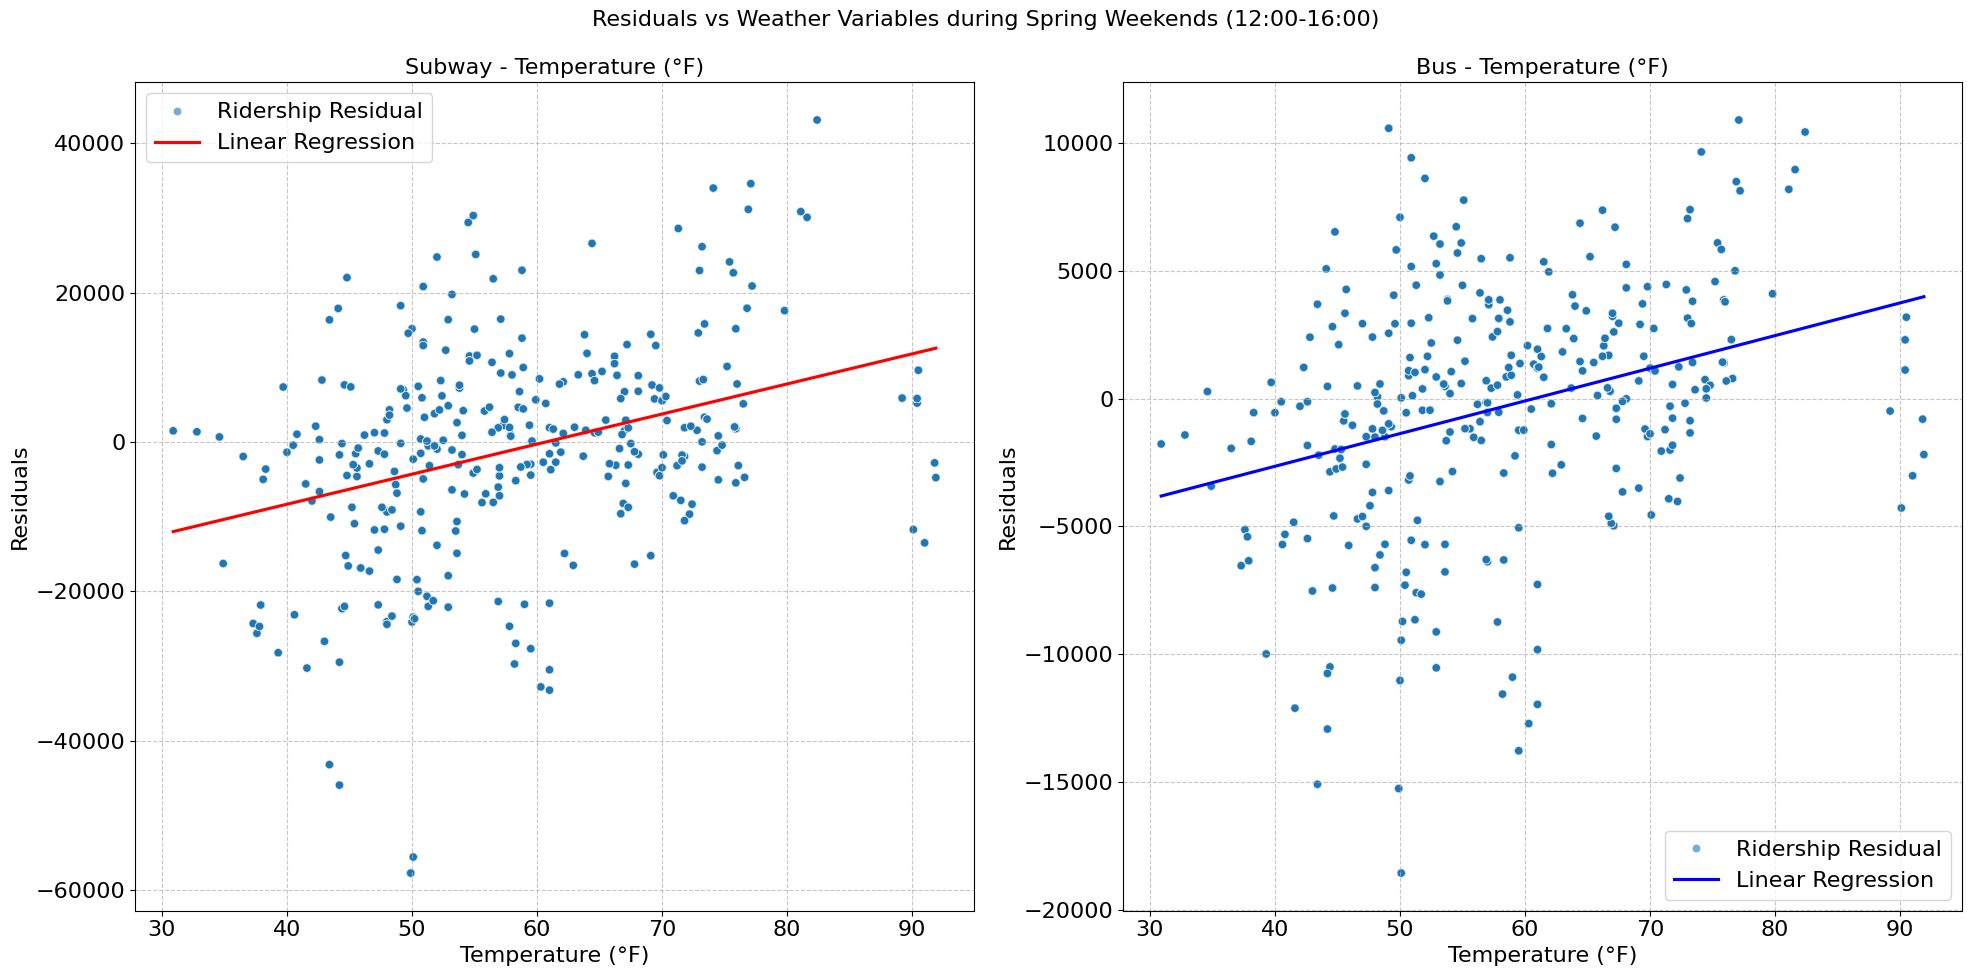

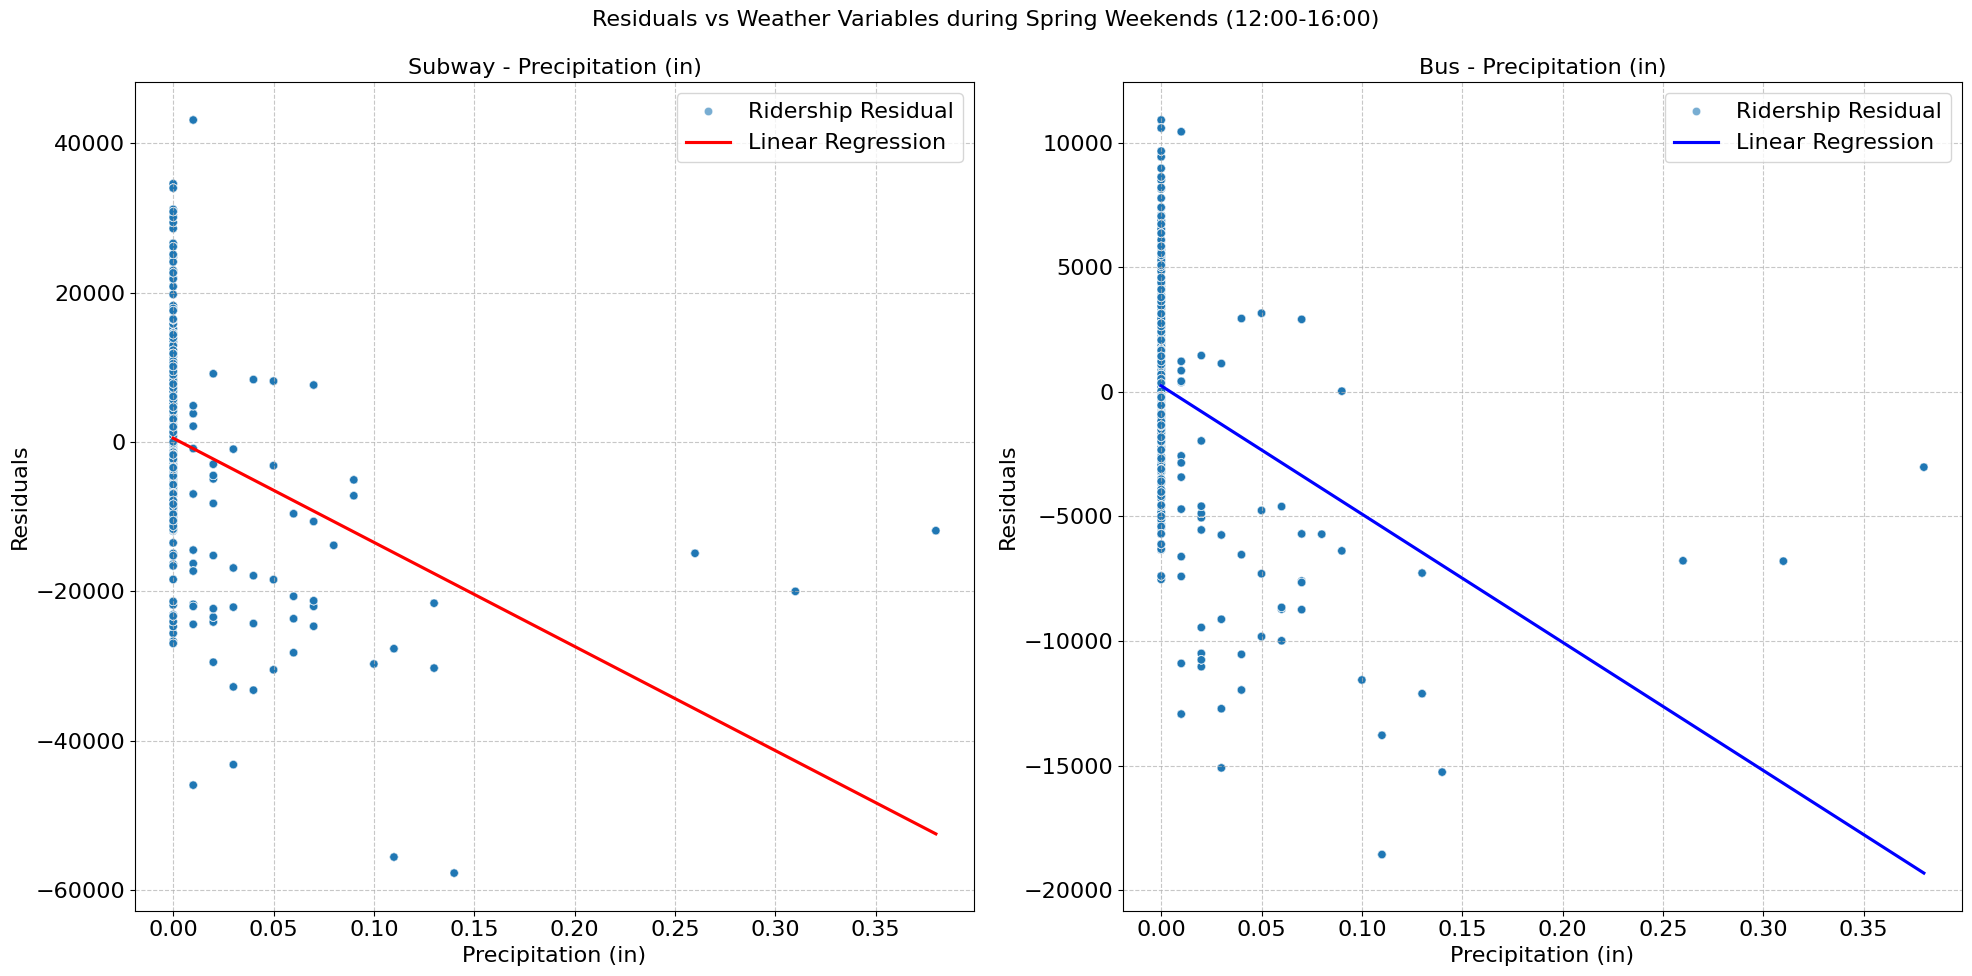

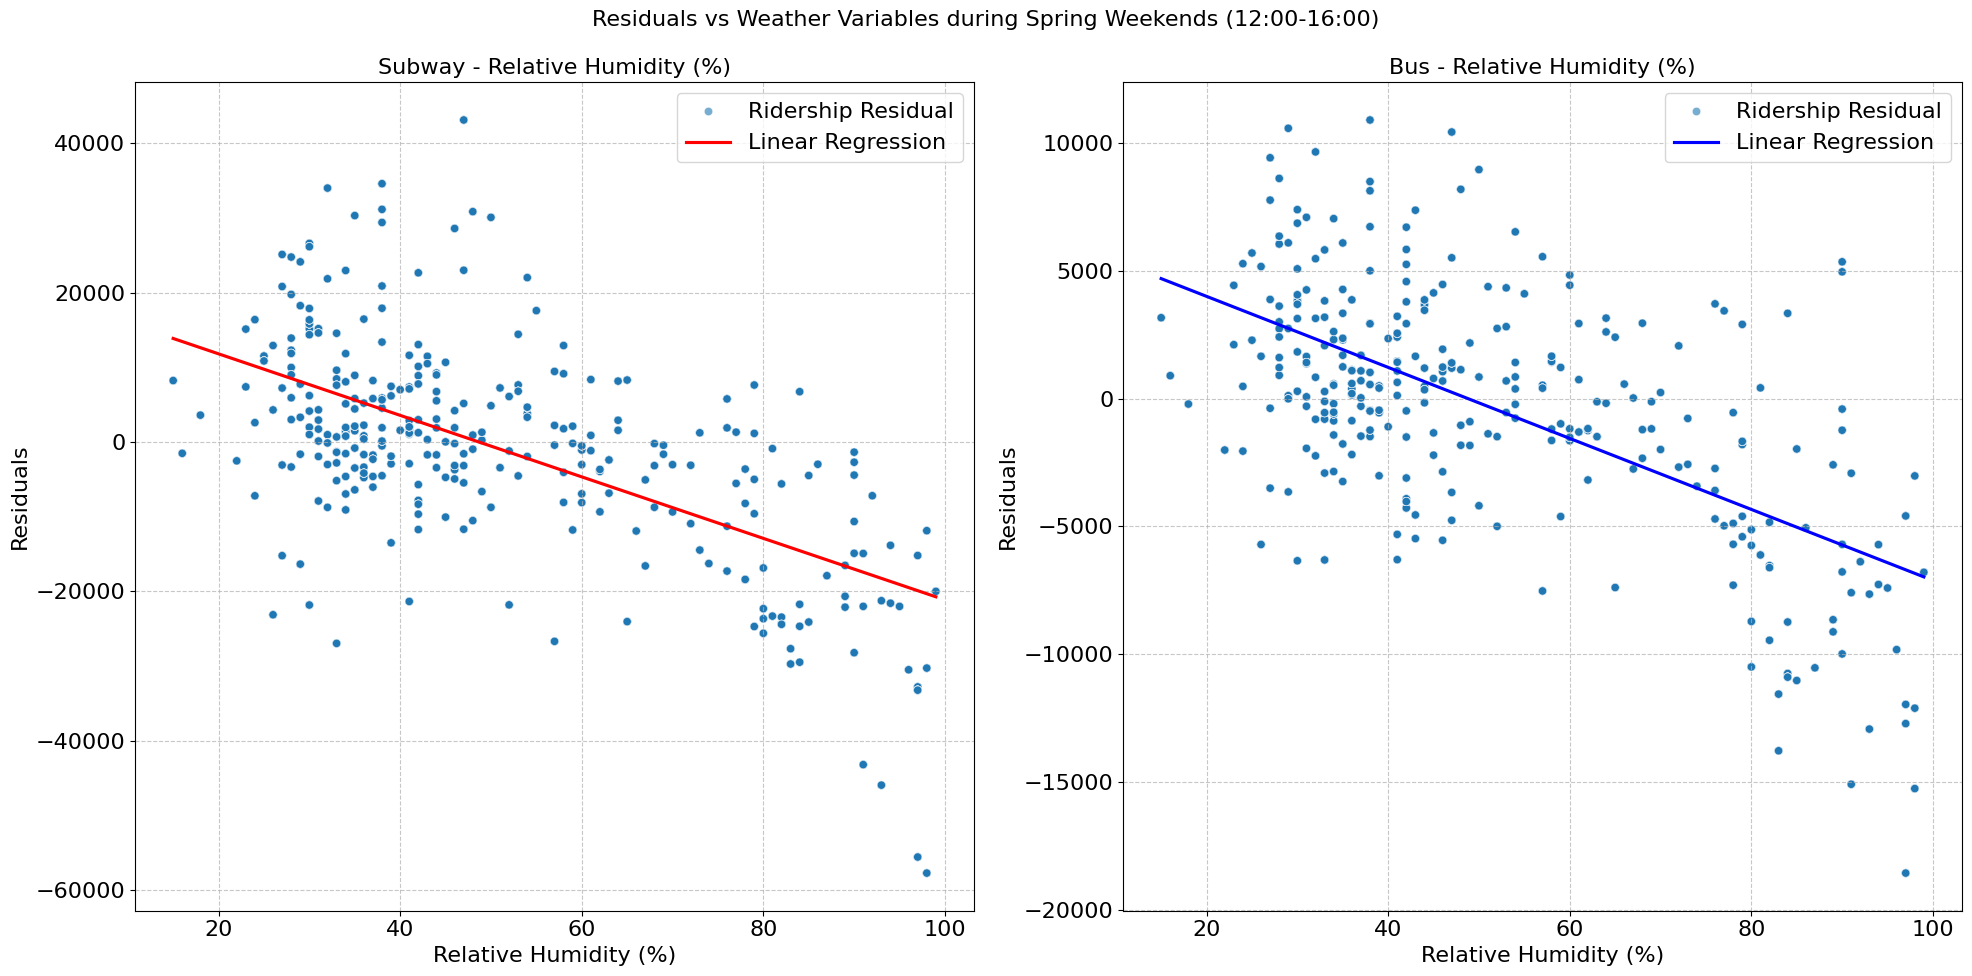

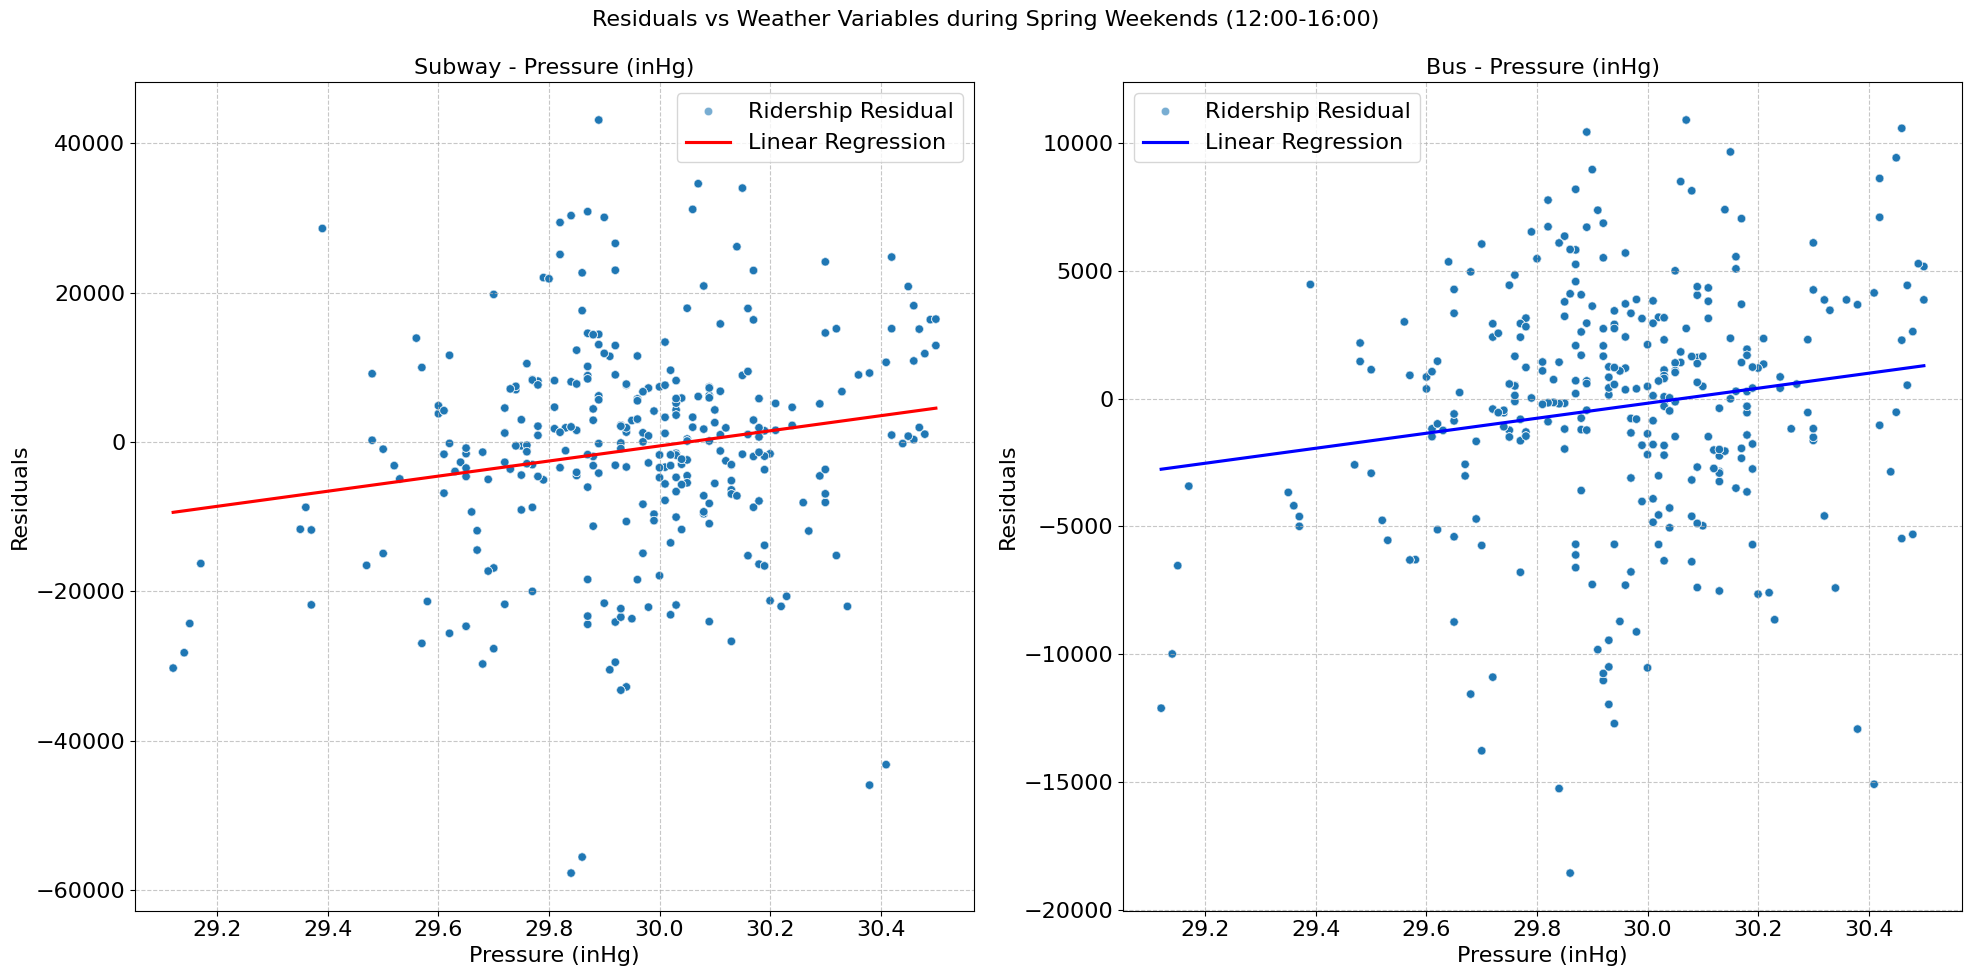

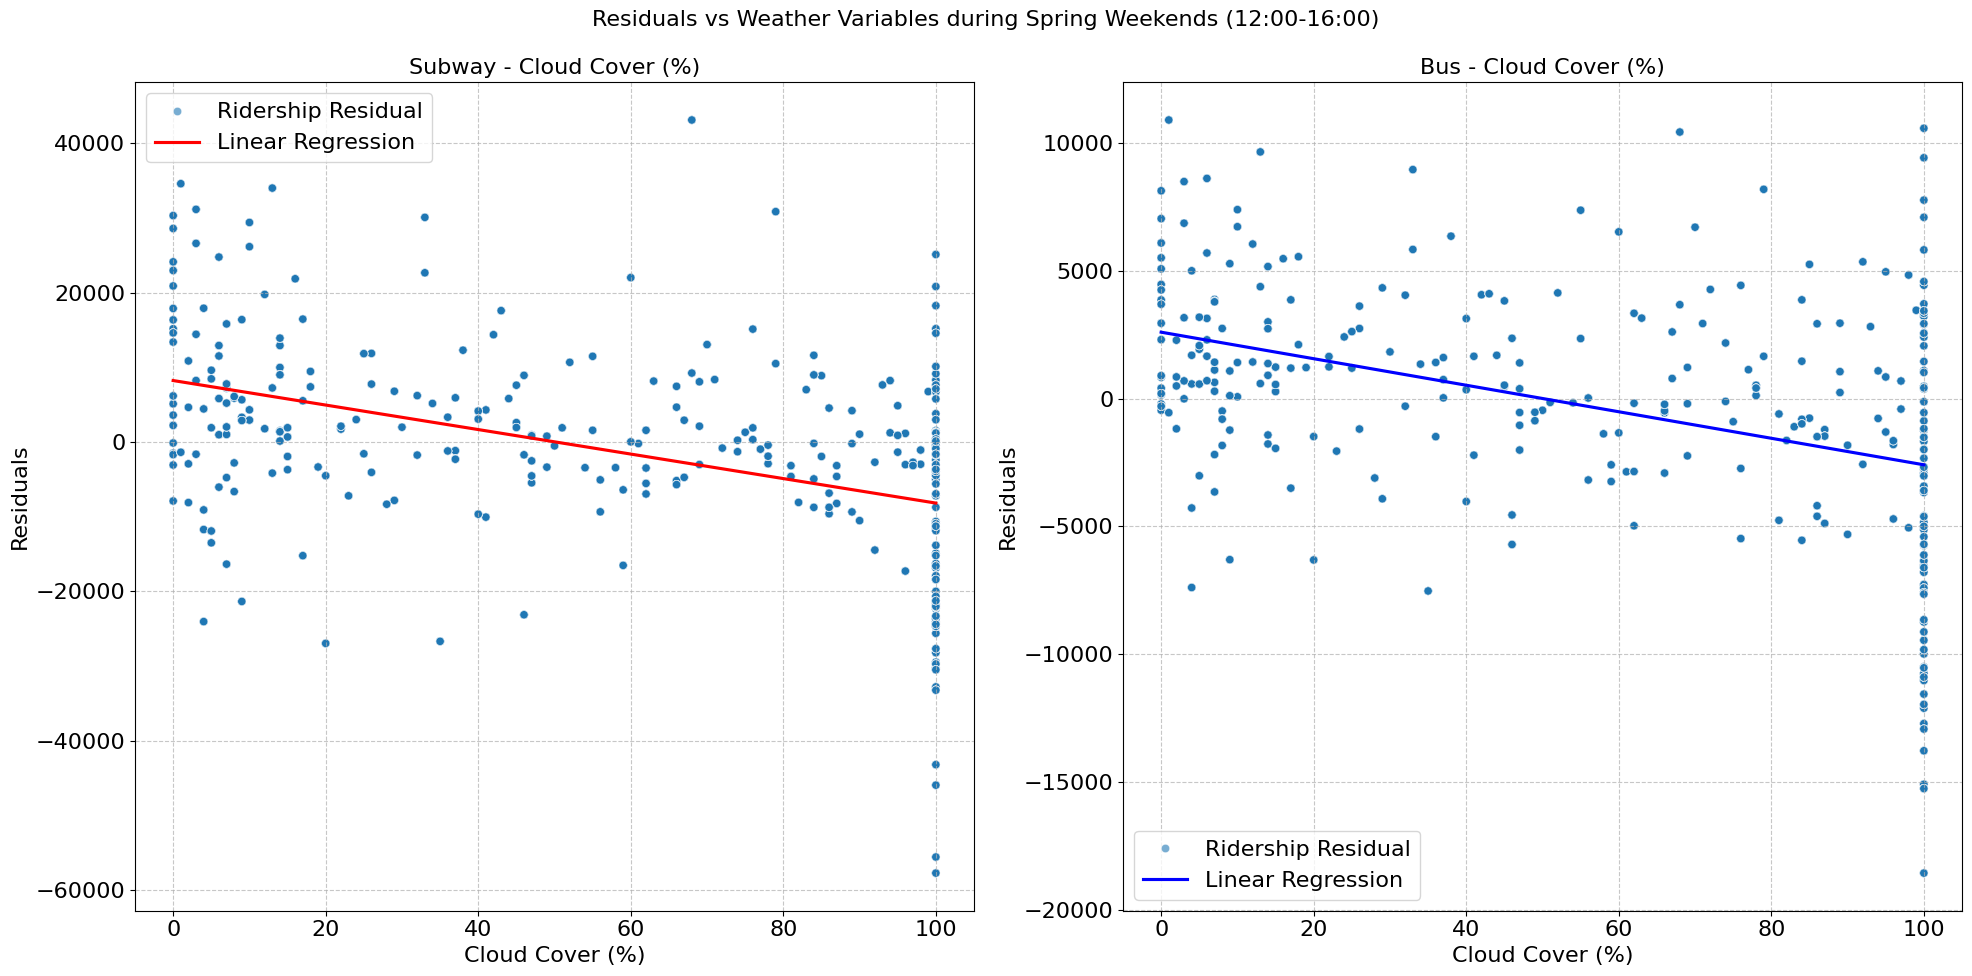

In [11]:
# Filter data for weekends and specified hour segments
weekend_mask = (combined_df['is_weekend'] == 1) & \
               (combined_df['hour'].dt.hour >= 12) & \
               (combined_df['hour'].dt.hour < 16) & \
               (combined_df['season'] == 'Spring')
weekend_data = combined_df[weekend_mask].copy()

# Create hour_segment column using loc
weekend_data.loc[:, 'hour_segment'] = pd.cut(weekend_data['hour'].dt.hour,
                                            bins=[12, 16],
                                            labels=['Ridership Residual'],
                                            include_lowest=True)

weather_vars = ['Temperature (°F)', 'Precipitation (in)', 'Relative Humidity (%)',
                'Pressure (inHg)', 'Cloud Cover (%)']
modes = ['subway', 'bus']

for i, var in enumerate(weather_vars):

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Residuals vs Weather Variables during Spring Weekends (12:00-16:00)', fontsize=16)

    for j, mode in enumerate(modes):
        ax = axs[j]
        
        # Calculate residuals
        residuals = weekend_data[f'{mode}_residual']
        
        # Create scatter plot
        sns.scatterplot(x=weekend_data[var], y=residuals, hue=weekend_data['hour_segment'], 
                        ax=ax, alpha=0.6)
        
        # Add linear regression line without shaded area
        sns.regplot(x=weekend_data[var], y=residuals, scatter=False, ax=ax, 
                    color='red' if mode == 'subway' else 'blue', label='Linear Regression', ci=None)
    
        ax.set_title(f'{mode.capitalize()} - {var}', fontsize=16)
        ax.set_xlabel(var, fontsize=16)
        ax.set_ylabel('Residuals', fontsize=16)
        ax.legend(fontsize=16)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()

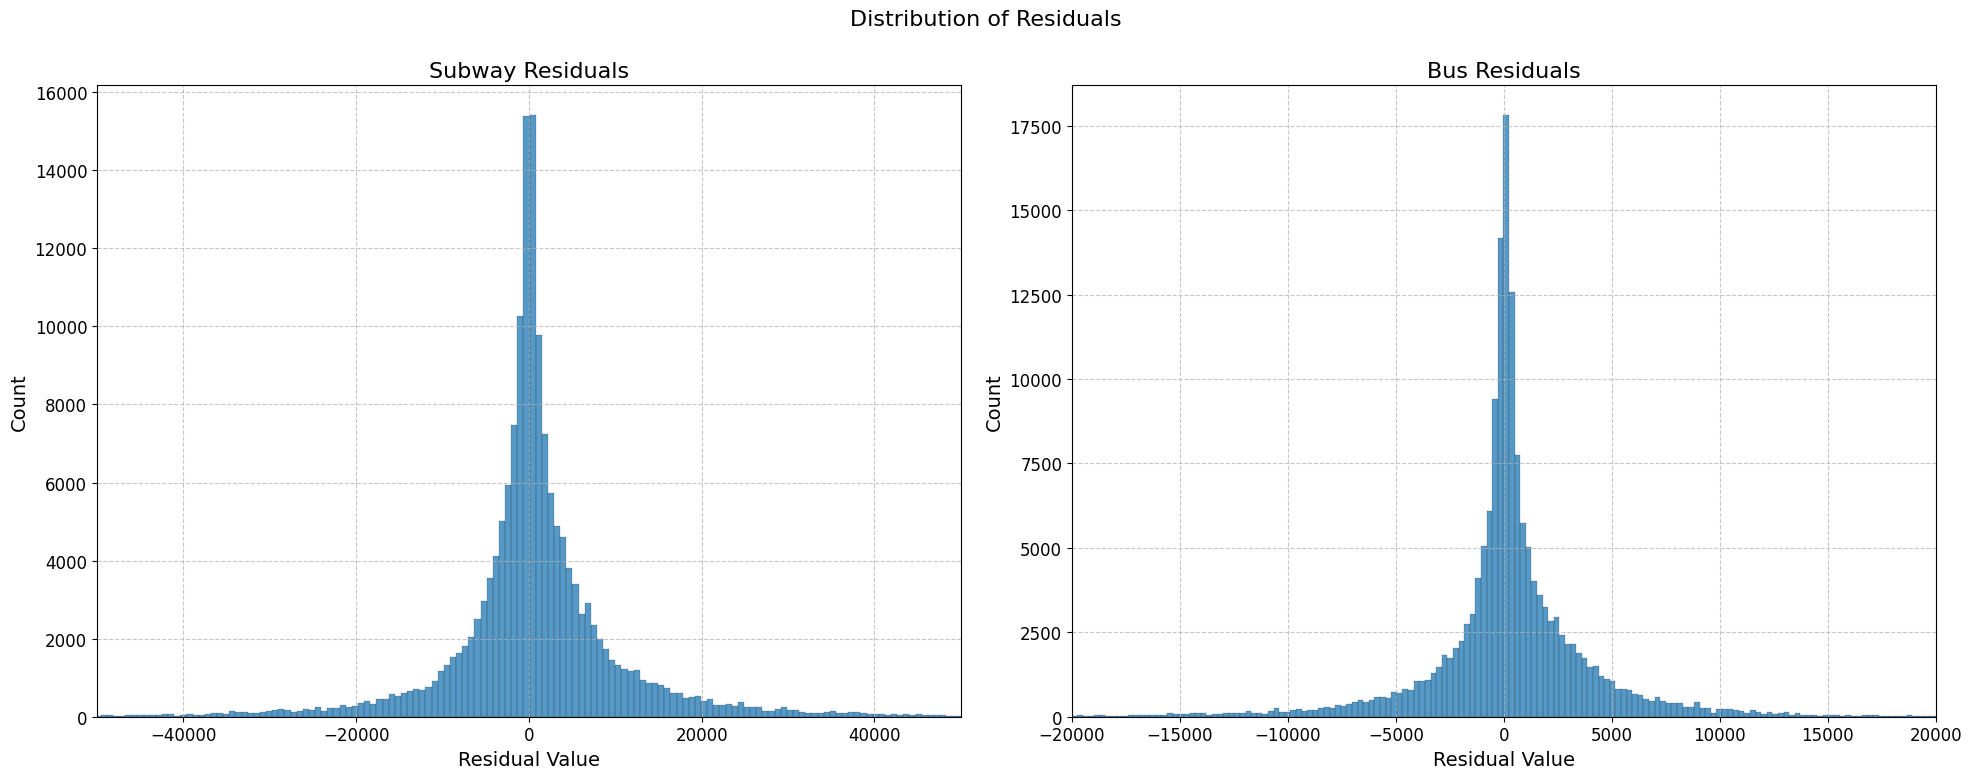

Mean absolute value of subway residuals: 7029.028714315474
Mean absolute value of bus residuals: 2636.884402607437


In [12]:
# Create histograms of residuals for subway and bus
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Distribution of Residuals', fontsize=16)

# Subway residuals histogram
sns.histplot(data=combined_df, x='subway_residual', ax=ax1, bins=400)
ax1.set_title('Subway Residuals', fontsize=16)
ax1.set_xlabel('Residual Value', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(-50000, 50000)
ax1.grid(True, linestyle='--', alpha=0.7)

# Bus residuals histogram
sns.histplot(data=combined_df, x='bus_residual', ax=ax2, bins=400)
ax2.set_title('Bus Residuals', fontsize=16)
ax2.set_xlabel('Residual Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(-20000, 20000)

plt.tight_layout()
plt.show()

# Print mean absolute value of residuals
print(f"Mean absolute value of subway residuals: {combined_df['subway_residual'].abs().mean()}")
print(f"Mean absolute value of bus residuals: {combined_df['bus_residual'].abs().mean()}")

In [13]:

# Run analysis
time_intervals = [
    TimeInterval('Spring', 'weekend', (12, 14))
]

# Initialize models
models = {
    'Linear': LinearModel(),
    'GLM': GLMModel(),
    'Quantile': QuantileModel(quantile=0.5),
    'Robust': RobustModel(),
    'GradientBoosting': GradientBoostingModel(),
    'XGBoost': XGBoostModel(n_estimators=10),
    'Naive': NaiveModel()
}

train_df, val_df = split_df_at_datetime(combined_df, pd.Timestamp('2023-11-16'))

results = {}

modes = ['subway', 'bus']

for time_interval in time_intervals:
    for mode in modes:
        print(f"\nAnalysis for {mode.capitalize()} - {time_interval.summary}")
        print("-" * 80)
        
        # results = run_model_analysis(models, combined_df, mode, season, day_type, hours)
        
        # for model_name, result in results.items():
        #     print(f"\n{model_name} Results:")
        #     print("Metrics:", result['train_metrics'])
        #     print("Summary:", result['summary'])

        results[f'{mode}_{time_interval.summary}'] = run_model_analysis(models, train_df, mode, time_interval, val_df)

        for model_name, result in results[f'{mode}_{time_interval.summary}'].items():
            print(f"\n{model_name} Results:")
            print("Train Metrics:", result['train_metrics'])
            print("Train Residuals:", result['train_residual'])
            print("Validation Metrics:", result['val_metrics'])
            print("Validation Residuals:", result['val_residual'])
            print("Summary:", result['summary'])




Analysis for Subway - Spring weekend (12, 14)
--------------------------------------------------------------------------------
Fitting Robust Model:
X shape: (728, 6)
Sample of X:       const  Temperature (°F)  Precipitation (in)  Relative Humidity (%)  \
5327    1.0              40.8                 0.0                     41   
5328    1.0              40.8                 0.0                     41   
5329    1.0              40.8                 0.0                     41   
5330    1.0              40.8                 0.0                     41   
5331    1.0              40.8                 0.0                     41   

      Cloud Cover (%)  Pressure (inHg)  
5327               90            30.48  
5328               90            30.48  
5329               90            30.48  
5330               90            30.48  
5331               90            30.48  
y shape: (728,)
Sample of y: 5327    1057.943508
5328    1057.943508
5329    1057.943508
5330    1057.943508
5331   

/Users/perryscott/Desktop/MTA-Weather-Based-Prediction/.mta_venv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


AttributeError: 'RLM' object has no attribute 'coef_'

In [ ]:
# Create bar plots comparing train vs validation MAE for each condition
import matplotlib.pyplot as plt
import numpy as np

def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Create a plot for each condition
for time_interval in time_intervals:
    for mode in modes:
        
        # Extract results for this condition
        condition_results = results[f'{mode}_{time_interval.summary}']
        
        # Extract MAE values for each model
        model_names = list(condition_results.keys())
        train_maes = [result['train_metrics']['MAE'] for result in condition_results.values()]
        val_maes = [result['val_metrics']['MAE'] for result in condition_results.values()]
        
        # Calculate mean absolute residuals
        train_residuals = np.mean([abs(result['train_residual']) for result in condition_results.values()])
        val_residuals = np.mean([abs(result['val_residual']) for result in condition_results.values()])

        # Set up bar plot
        x = np.arange(len(model_names))
        width = 0.35

        fig, ax = plt.subplots(figsize=(16, 8))
        train_bars = ax.bar(x - width/2, train_maes, width, label='Train MAE')
        val_bars = ax.bar(x + width/2, val_maes, width, label='Validation MAE')
        
        # Add horizontal lines for mean absolute residuals
        ax.axhline(y=train_residuals, color='blue', linestyle=':', label='Train Mean Absolute Residual')
        ax.axhline(y=val_residuals, color='orange', linestyle=':', label='Validation Mean Absolute Residual')

        # Customize plot
        ax.set_ylabel('Mean Absolute Error')
        ax.set_title(f'Model Performance Comparison: {mode.capitalize()} - {time_interval.summary}')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names)
        ax.legend()

        # Add value labels on bars
        autolabel(ax, train_bars)
        autolabel(ax, val_bars)

        plt.tight_layout()
        plt.show()


In [ ]:
# Define time intervals for parameter search
time_intervals = [
    TimeInterval('Spring', 'weekend', (12, 14)),
    TimeInterval('Spring', 'weekend', (8, 10))
]

# Get all possible feature combinations
feature_combinations = generate_feature_combinations([
    ModelParameters.TEMPERATURE,
    ModelParameters.PRECIPITATION, 
    ModelParameters.HUMIDITY,
    ModelParameters.CLOUD_COVER,
    ModelParameters.PRESSURE
])

print(f"Number of feature combinations: {len(feature_combinations)}")

# Run parameter search for each mode
modes = ['subway', 'bus']
search_results = {}

for mode in modes:
    # Evaluate models with different parameter combinations
    mode_results = evaluate_models(
        models=models,
        train_data=train_df,
        val_data=val_df,
        mode=mode,
        time_intervals=time_intervals,
        parameter_combinations=feature_combinations
    )
    
    # Store results
    search_results[mode] = mode_results

    print("mode_results", mode_results)
    
    # Print top 5 feature combinations for this mode
    n = 50
    print(f"\nTop {n} feature combinations for {mode}:")
    for (model_name, params), score in mode_results[:n]:
        param_names = [p.value for p in params]
        print(f"Score: {score:.4f} - Features: {param_names} - Model: {model_name}")
